# Project Details
This Machine Learning Project is about multiclass classification of Crime Category. The Dataset contains narrative about the crime incident such as location, victim demographics, victim age, weapon used by assailant, assailant's modus operandi etc.

* Accuracy Score is used for evalution
* train.csv is the labeled input file
* test.csv is the unlabeled file
* submission.csv is the labels for test.csv file  

# Library Imports and Data Loading

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
from sklearn.tree import plot_tree
import re
from pandas.tseries.holiday import USFederalHolidayCalendar

# Preprocessing packages
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, label_binarize, LabelEncoder, MinMaxScaler, FunctionTransformer
from sklearn.feature_extraction.text import CountVectorizer

# Model training packages
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, StackingClassifier, VotingClassifier

# Model evalution packages
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, auc, roc_curve, precision_recall_curve

# to supress python warnings in output
import warnings, sys, os
import logging
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

# Data Loading
train_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/train.csv', 
                        parse_dates=["Date_Reported", "Date_Occurred"])
test_data = pd.read_csv('/kaggle/input/crime-cast-forecasting-crime-categories/test.csv', 
                       parse_dates=["Date_Reported", "Date_Occurred"])


print("Log: train_data, labels and test_data are loaded!")
print("Train Data Shape".ljust(20, ' '), train_data.shape)
print("Test Data Shape".ljust(20, ' '), test_data.shape)

# checking for duplicates in the data
print("Train Duplicates".ljust(20, ' '), train_data.duplicated().sum())
print("Test Duplicates".ljust(20, ' '), test_data.duplicated().sum())
# train_data.drop_duplicates(inplace=True)

# target labels
labels = train_data.Crime_Category

# first 4 samples
train_data.head(4)

Log: train_data, labels and test_data are loaded!
Train Data Shape     (20000, 22)
Test Data Shape      (5000, 21)
Train Duplicates     13
Test Duplicates      3


Location                     Cross_Street  \
0   4500    CARPENTER                    AV                              NaN   
1           45TH                         ST  ALAMEDA                      ST   
2    600 E  MARTIN LUTHER KING JR        BL                              NaN   
3  14900    ORO GRANDE                   ST                              NaN   

   Latitude  Longitude Date_Reported Date_Occurred  Time_Occurred  Area_ID  \
0   34.1522  -118.3910    2020-03-09    2020-03-06         1800.0     15.0   
1   34.0028  -118.2391    2020-02-27    2020-02-27         1345.0     13.0   
2   34.0111  -118.2653    2020-08-21    2020-08-21          605.0     13.0   
3   34.2953  -118.4590    2020-11-08    2020-11-06         1800.0     19.0   

     Area_Name  Reporting_District_no  ...  Victim_Age Victim_Sex  \
0  N Hollywood                 1563.0  ...        75.0          M   
1       Newton                 1367.0  ...        41.0          M   
2       Newton                 1343.0  ...        67.0          M   
3      Mission                 1924.0  ...        61.0          M   

   Victim_Descent Premise_Code     Premise_Description  Weapon_Used_Code  \
0               W        101.0                  STREET               NaN   
1               H        216.0               SWAP MEET             400.0   
2               B        501.0  SINGLE FAMILY DWELLING               NaN   
3               H        101.0                  STREET               NaN   

                               Weapon_Description  Status Status_Description  \
0                                             NaN      IC        Invest Cont   
1  STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)      IC        Invest Cont   
2                                             NaN      IC        Invest Cont   
3                                             NaN      IC        Invest Cont   

    Crime_Category  
0  Property Crimes  
1  Property Crimes  
2  Property Crimes  
3  Property Crimes  

[4 rows x 22 columns]

In [2]:
train_data.info()
# train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Location               20000 non-null  object        
 1   Cross_Street           3448 non-null   object        
 2   Latitude               20000 non-null  float64       
 3   Longitude              20000 non-null  float64       
 4   Date_Reported          20000 non-null  datetime64[ns]
 5   Date_Occurred          20000 non-null  datetime64[ns]
 6   Time_Occurred          20000 non-null  float64       
 7   Area_ID                20000 non-null  float64       
 8   Area_Name              20000 non-null  object        
 9   Reporting_District_no  20000 non-null  float64       
 10  Part 1-2               20000 non-null  float64       
 11  Modus_Operandi         17259 non-null  object        
 12  Victim_Age             20000 non-null  float64       
 13  V

In [3]:
# train_data.describe(include='object')

In [4]:
# pairplot = sns.pairplot(train_data.select_dtypes(['float']))
# plt.suptitle('Pairplot of Numerical Features', y=1.02)
# plt.show()

# Exploratory Data Analysis (EDA)

* Reporting_District_no and Longitue can be dropped

# Labels distribution
**Crime_Category**: The category of the crime (Target Variable)

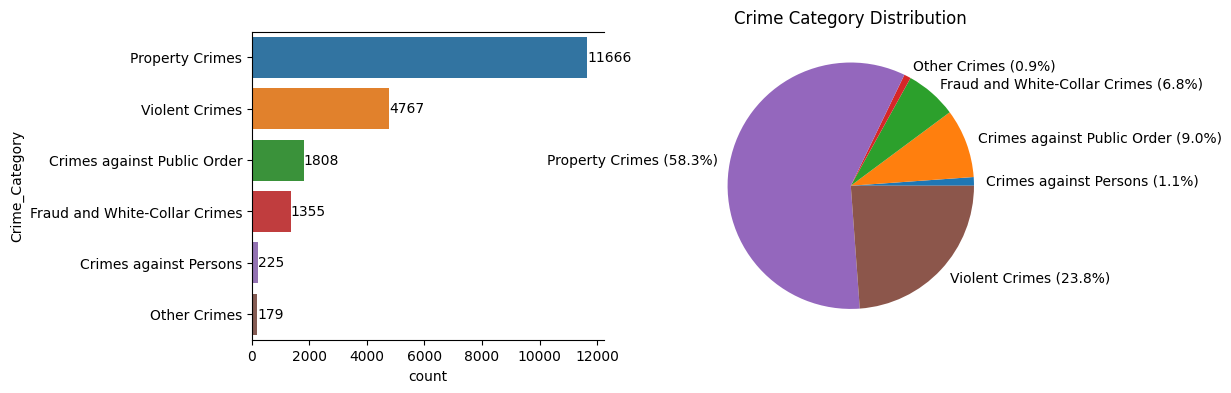

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

sns.countplot(train_data, 
             y='Crime_Category',
             order=train_data.Crime_Category.value_counts().index,
             ax=axs[0])
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d')
axs[0].spines['right'].set_visible(0)
axs[0].spines['top'].set_visible(1)


unique, counts = np.unique(labels, return_counts=True)
axs[1].pie(counts, 
           labels=[f'{label} ({c/200:.1f}%)' for label, c in zip(unique, counts)], 
           autopct='')
axs[1].set_title('Crime Category Distribution')
# plt.tight_layout()
plt.show()

* More than half of the data is **Property Crimes (58.3%)** and second highest is **Violent Crimes (23.8%)** totaling to **82.1%** clearly shows data is imbalanced

# Missing Data (Null Values)

In [6]:
train_data.isin([np.nan, -2, -1, 0]).sum().sort_values(ascending=False)[:12]#/200

Cross_Street           16552
Weapon_Description     12665
Weapon_Used_Code       12665
Victim_Age              4834
Modus_Operandi          2741
Victim_Sex              2624
Victim_Descent          2624
Latitude                  78
Longitude                 78
Premise_Description        5
Status_Description         0
Status                     0
dtype: int64

# Missing Data Classwise

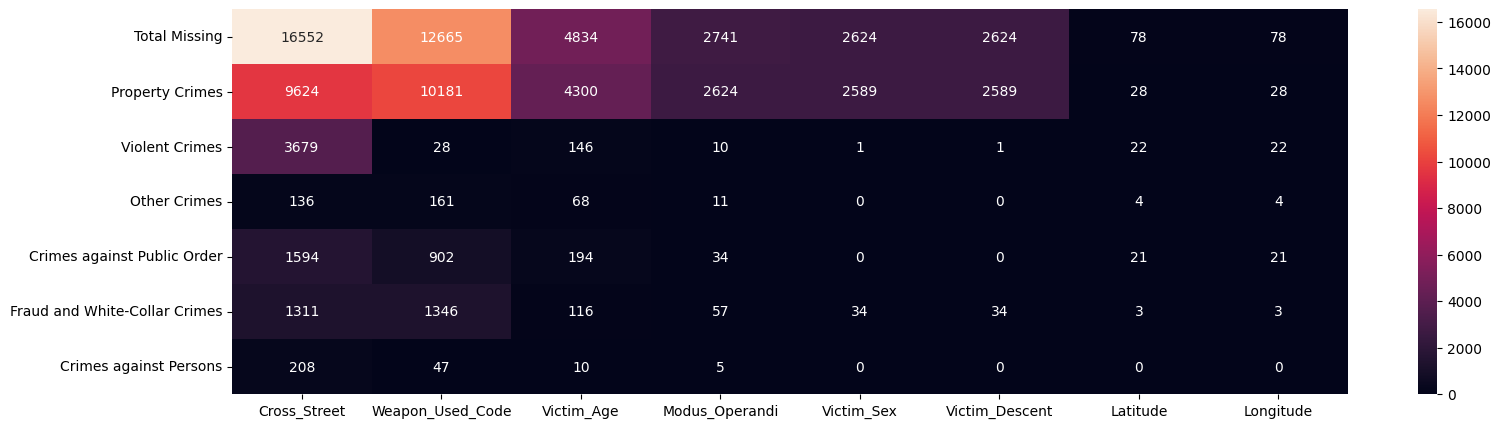

In [7]:
df = train_data.copy()

columns_to_check = ['Cross_Street', 'Weapon_Used_Code', 'Victim_Age',
                    'Modus_Operandi', 'Victim_Sex', 
                    'Victim_Descent', 
                     'Latitude', 'Longitude']

missing_values_matrix = {}

for col in columns_to_check:
    missing_values_matrix[col] = {}
    total_missing = df[col].isin([np.nan, -2, -1, 0]).sum()
    missing_values_matrix[col]['Total Missing'] = total_missing #/200
    
    for crime in df.Crime_Category.unique():
        crime_data = df[df.Crime_Category == crime]
        nulls = crime_data[col].isin([np.nan, -2, -1, 0]).sum()
        missing_values_matrix[col][crime] = nulls #/200    

missing_values_df = pd.DataFrame(missing_values_matrix).T


plt.figure(figsize=(18, 5))
sns.heatmap(missing_values_df.T, annot=True, fmt="d")
plt.xticks(rotation=0)
plt.show()

## Feature Correlation

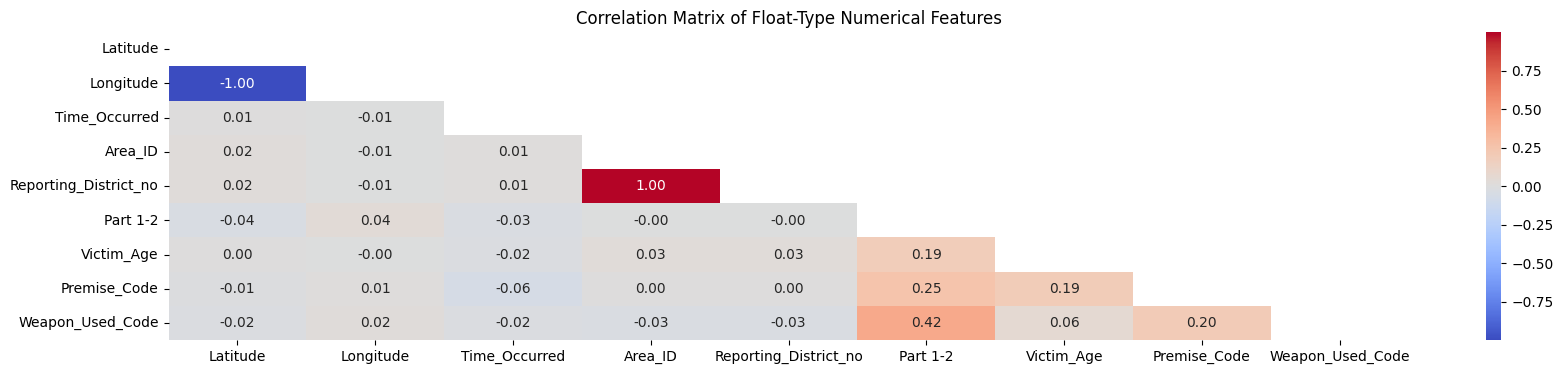

In [8]:
plt.figure(figsize=(20, 4))
correlation_matrix = train_data.select_dtypes(['float']).corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=0)
sns.heatmap(correlation_matrix, 
            mask=mask, annot=True, fmt='.2f', 
            cmap='coolwarm')
plt.title('Correlation Matrix of Float-Type Numerical Features')
plt.xticks(rotation=0)
plt.show()

## Feature Target Relations

# Location
Street address of the crime incident.

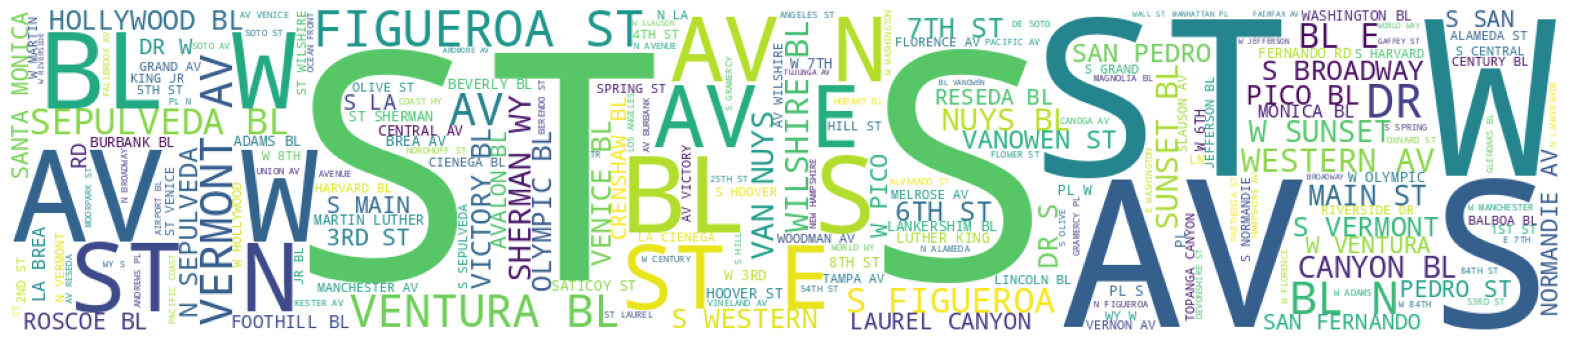

------------------Few Locations-------------------
0     4500    CARPENTER                    AV
1             45TH                         ST
2      600 E  MARTIN LUTHER KING JR        BL
3    14900    ORO GRANDE                   ST
4     7100 S  VERMONT                      AV
Name: Location, dtype: object


In [9]:
# wordcloud of Locations
text = " ".join(address for address in train_data['Location'])
wordcloud = WordCloud(
                      width=1200, 
                      height=250, 
                      background_color='white').generate(text)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

print("Few Locations".center(50, '-'))
print(train_data['Location'][:5])
# train_data['Location'].value_counts(normalize=1)

* Unique Locations count: 12,399 among 20,000
* Most frequent Location (6TH) appeared: 0.1%
* Least frequent Location (DALTON AV): 0.005%

## Feature Engineering

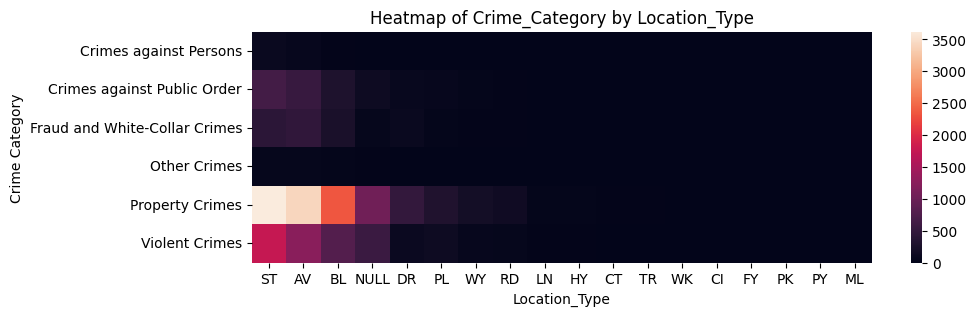

In [10]:
df=train_data.copy()
df['Location_Type'] = df.Location.apply(lambda x: re.split(r'\s{2,}', x)[-1])\
.apply(lambda x: x if len(x)==2 else np.nan).fillna('NULL')
grouped = df.groupby(['Crime_Category', 
                              'Location_Type']).size().unstack(fill_value=0)
plt.figure(figsize=(10, 3))
sns.heatmap(grouped.loc[:, df.Location_Type.value_counts().index],
            annot=False, fmt="d")
plt.title('Heatmap of Crime_Category by Location_Type')
plt.ylabel('Crime Category')
plt.xlabel('Location_Type')
plt.show()

### Cross_Street
Cross street of the rounded address.

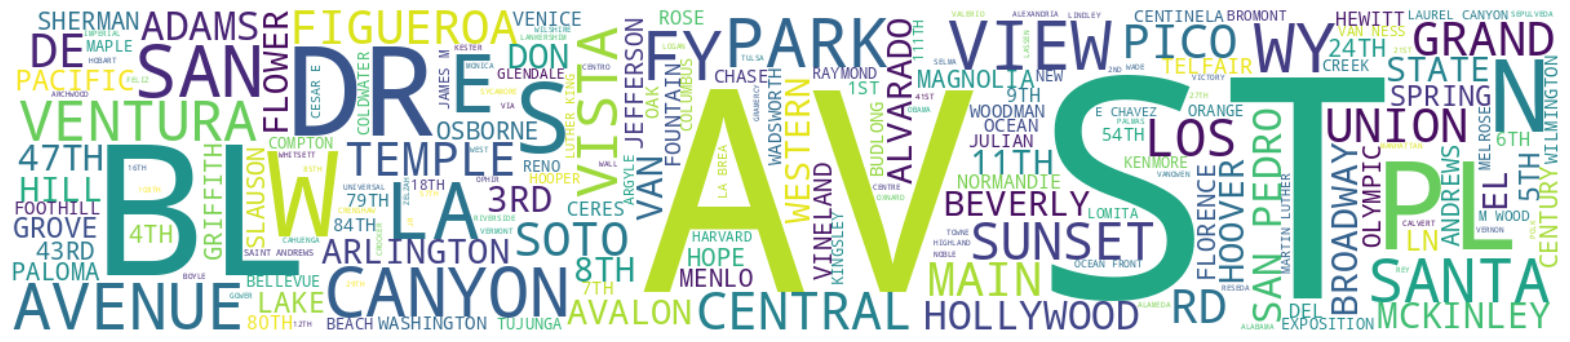

--------------Cross_Street Frequency--------------
Cross_Street
BROADWAY                           56
FIGUEROA                           43
VERMONT                      AV    40
FIGUEROA                     ST    34
MAIN                               33
Name: count, dtype: int64


In [11]:
# wordcloud of Cross_Street
text = " ".join(str(address) for address in train_data['Cross_Street'].unique())
wordcloud = WordCloud(width=1200, 
                      height=250, background_color='white').generate(text)
plt.figure(figsize=(20, 5))
plt.imshow(wordcloud, 
           interpolation='bilinear')
plt.axis('off')
plt.show()

print("Cross_Street Frequency".center(50, "-"))
print(train_data.Cross_Street.value_counts(normalize=0)[:5])

* Missing Cross_Street: 16552 (82.76%)
* Unique Cross_Street: 1495

Total 16552 Nulls


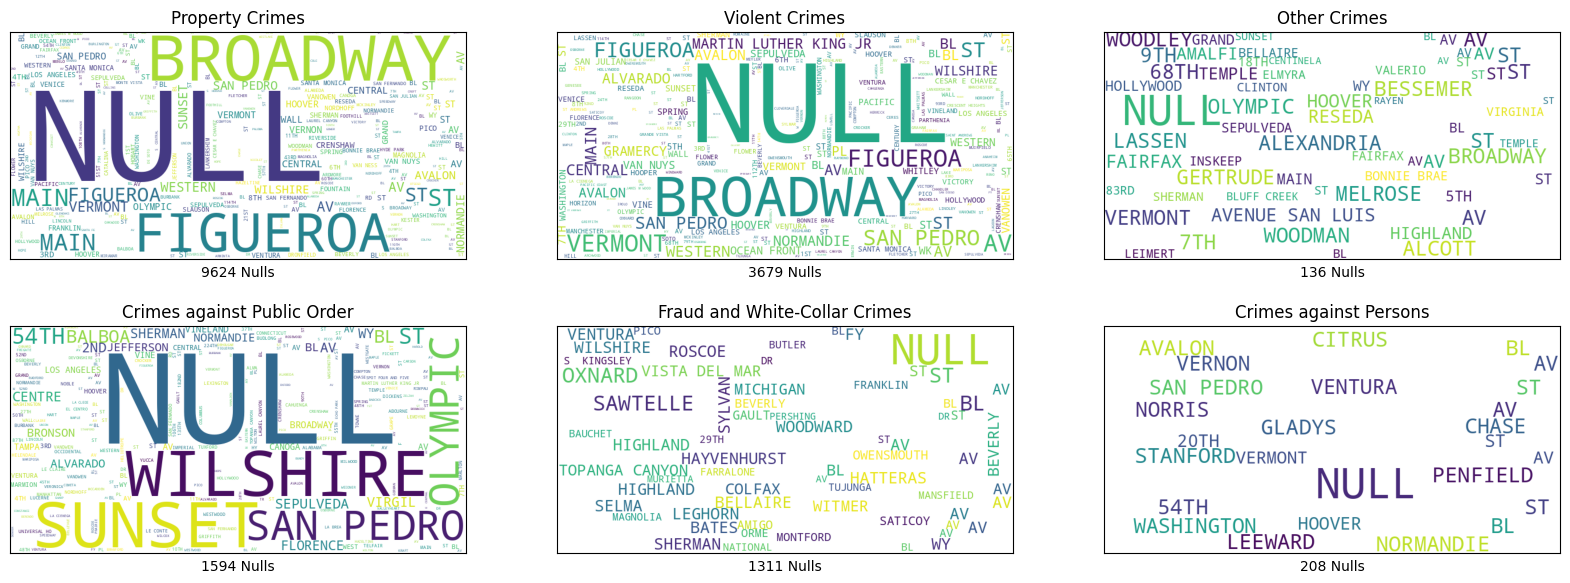

In [12]:
print(f"Total {df.Cross_Street.isna().sum()} Nulls")
fig, axes = plt.subplots(2, 3, figsize=(20, 7))

# Classwise Modus Operandi
for i, crime in enumerate(df.Crime_Category.unique()):
    mo_count = Counter(df[df.Crime_Category==crime].Cross_Street.fillna('NULL'))
    wordcloud = WordCloud(width=800, 
                  height=400, 
                 background_color='white').generate_from_frequencies(mo_count)
    axes[i//3, i%3].imshow(wordcloud)
    axes[i//3, i%3].axis('on')
    axes[i//3, i%3].set_xticks([])
    axes[i//3, i%3].set_yticks([])
    axes[i//3, i%3].set_title(f'{crime}')
    axes[i//3, i%3].set_xlabel(f"{mo_count['NULL']} Nulls")
plt.show()

# Area_ID
LAPD's Geographic Area number.
* Los Angeles Police Department Geographic Area

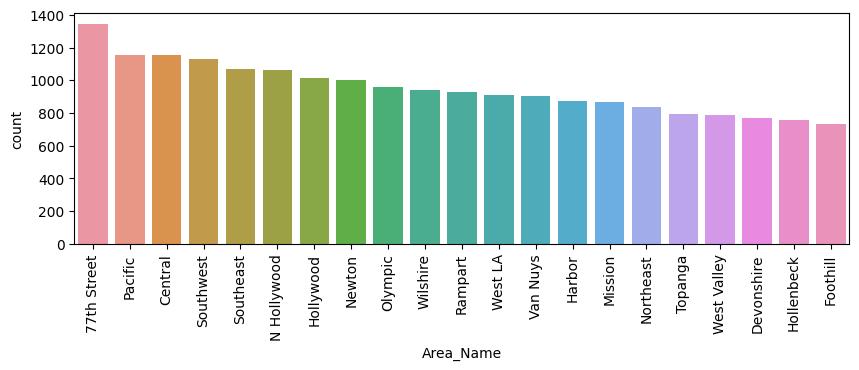

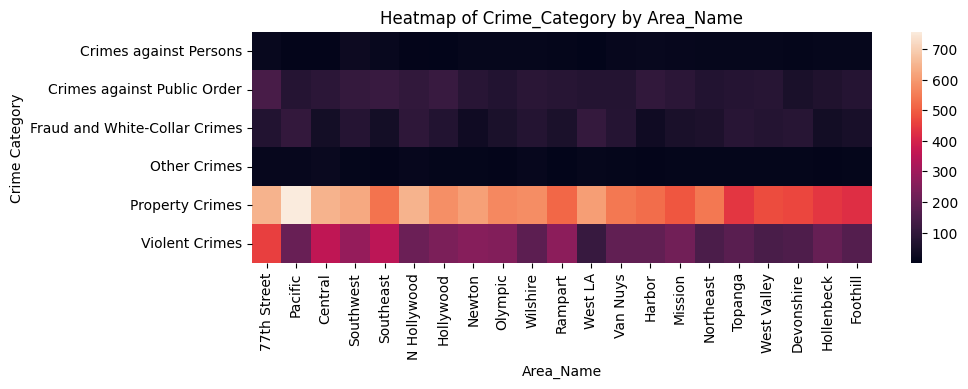

In [13]:
train_data.Area_ID = train_data.Area_ID.astype('int')
grouped = train_data.groupby(['Crime_Category', 
                              'Area_Name']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 3))
sns.countplot(data=train_data, x="Area_Name", 
              order=train_data.Area_Name.value_counts().index)
plt.xticks(rotation=90)
plt.show()

# heat map with Crime Category
plt.figure(figsize=(10, 3))
sns.heatmap(grouped.loc[:, train_data.Area_Name.value_counts().index],
            annot=False, fmt="d")
plt.title('Heatmap of Crime_Category by Area_Name')
plt.ylabel('Crime Category')
plt.xlabel('Area_Name')
plt.show()


# output = sorted(dict(zip(train_data.Area_ID, train_data.Area_Name)).items(), key=lambda x: x[0])

# Premise_Code
Premise code indicating the location of the crime.

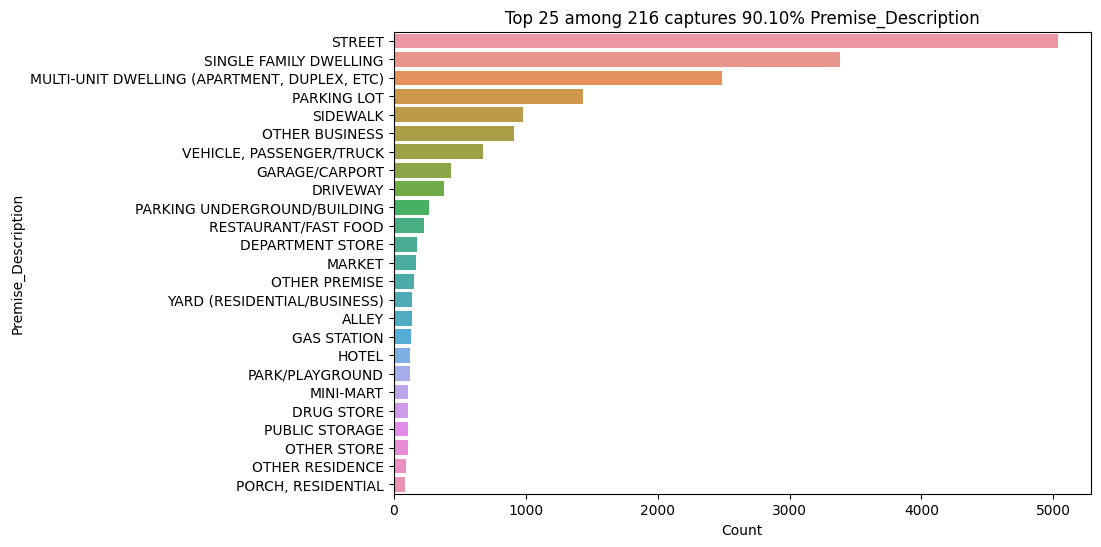

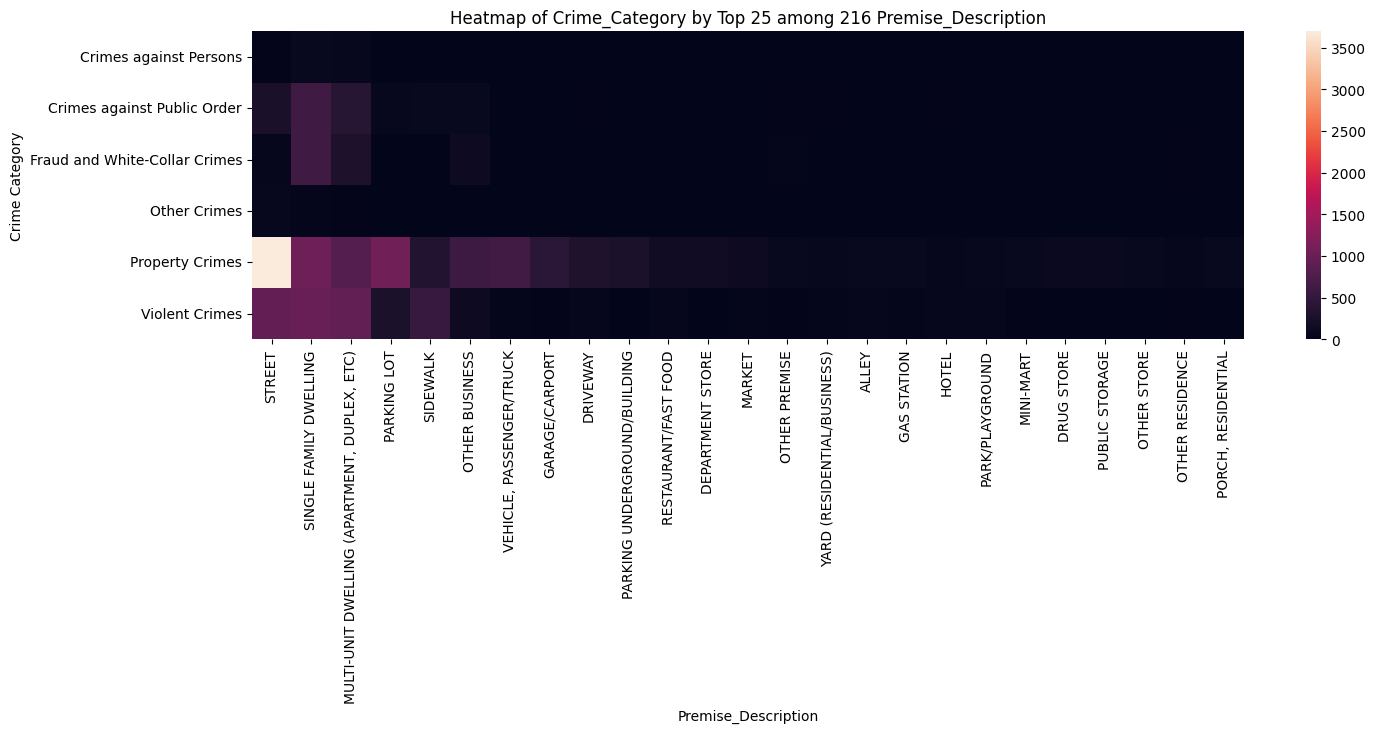

In [14]:
grouped = train_data.groupby(['Crime_Category', 
                              'Premise_Description']).size().unstack(fill_value=0)

plt.figure(figsize=(9, 6))
sns.countplot(data=train_data, y="Premise_Description", 
              order=train_data['Premise_Description'].value_counts().nlargest(25).index)
plt.title(f'Top 25 among 216 captures \
{sum(train_data.Premise_Description.value_counts(normalize=1)[:25]*100):.2f}% \
Premise_Description')
plt.xlabel('Count')
plt.ylabel('Premise_Description')
plt.show()

# heat map with Crime Category
plt.figure(figsize=(16, 4))
sns.heatmap(grouped.loc[:, train_data.Premise_Description.value_counts().index[:25]], 
            annot=False, fmt="d")
plt.title('Heatmap of Crime_Category by Top 25 among 216 Premise_Description')
plt.ylabel('Crime Category')
plt.xlabel('Premise_Description')
plt.show()


# output = sorted(dict(zip(train_data.Premise_Description, 
#                          train_data.Area_Name)).items(), key=lambda x: x[0])

#  Modus_Operandi
Activities associated with the suspect.

Total 2741 Nulls


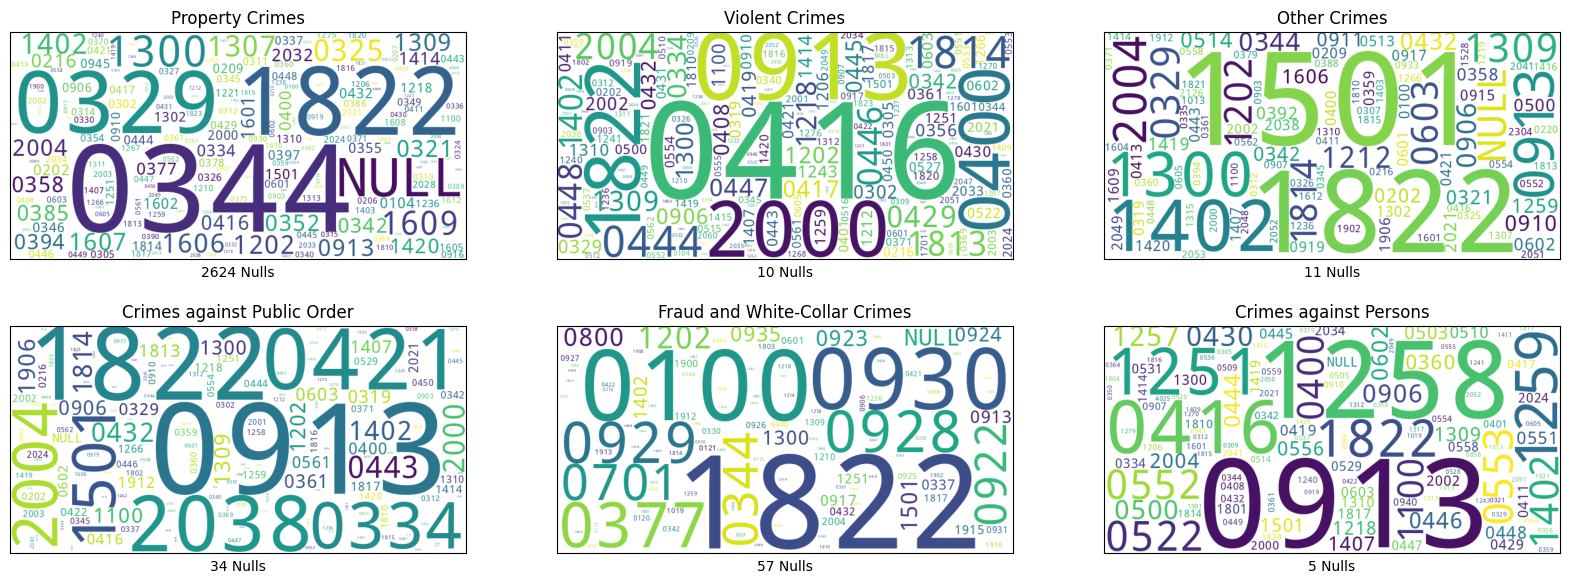

In [15]:
print(f"Total {df.Modus_Operandi.isna().sum()} Nulls")
fig, axes = plt.subplots(2, 3, figsize=(20, 7))

# Classwise Modus Operandi
for i, crime in enumerate(df.Crime_Category.unique()):
    mo_count = Counter(df[df.Crime_Category==crime].Modus_Operandi.fillna('NULL').\
                       str.split().explode())
    wordcloud = WordCloud(width=800, 
                  height=400, 
                 background_color='white').generate_from_frequencies(mo_count)
    axes[i//3, i%3].imshow(wordcloud)
    axes[i//3, i%3].axis('on')
    axes[i//3, i%3].set_xticks([])
    axes[i//3, i%3].set_yticks([])
    axes[i//3, i%3].set_title(f'{crime}')
    axes[i//3, i%3].set_xlabel(f"{mo_count['NULL']} Nulls")
plt.show()

## Feature Engineering

In [16]:
# print(train_data.Modus_Operandi)
df = train_data.copy()
from sklearn.feature_extraction.text import CountVectorizer
sample_mo = df.Modus_Operandi[:5]
cvectorizer = CountVectorizer()
mo_matrix = cvectorizer.fit_transform(df.Modus_Operandi[:5].values.tolist()).toarray()
mo_df = pd.DataFrame(mo_matrix, 
                     columns=['mo_'+n for n in cvectorizer.get_feature_names_out()])
pd.concat([pd.DataFrame({'Modus_Operandi': sample_mo}), mo_df], axis=1)

Modus_Operandi  mo_0329  mo_0344  mo_0352  \
0                                     0385        0        0        0   
1  0906 0352 0371 0446 1822 0344 0416 0417        0        1        1   
2                                0329 1202        1        0        0   
3                                0329 1300        1        0        0   
4            0416 0945 1822 0400 0417 0344        0        1        0   

   mo_0371  mo_0385  mo_0400  mo_0416  mo_0417  mo_0446  mo_0906  mo_0945  \
0        0        1        0        0        0        0        0        0   
1        1        0        0        1        1        1        1        0   
2        0        0        0        0        0        0        0        0   
3        0        0        0        0        0        0        0        0   
4        0        0        1        1        1        0        0        1   

   mo_1202  mo_1300  mo_1822  
0        0        0        0  
1        0        0        1  
2        1        0        0  
3        0        1        0  
4        0        0        1

# Victim_Age
Age of the victim.

In [17]:
# Victim_Age description
print(train_data.Victim_Age.describe())

count    20000.000000
mean        30.135000
std         21.863645
min         -2.000000
25%         12.000000
50%         31.000000
75%         46.000000
max         99.000000
Name: Victim_Age, dtype: float64


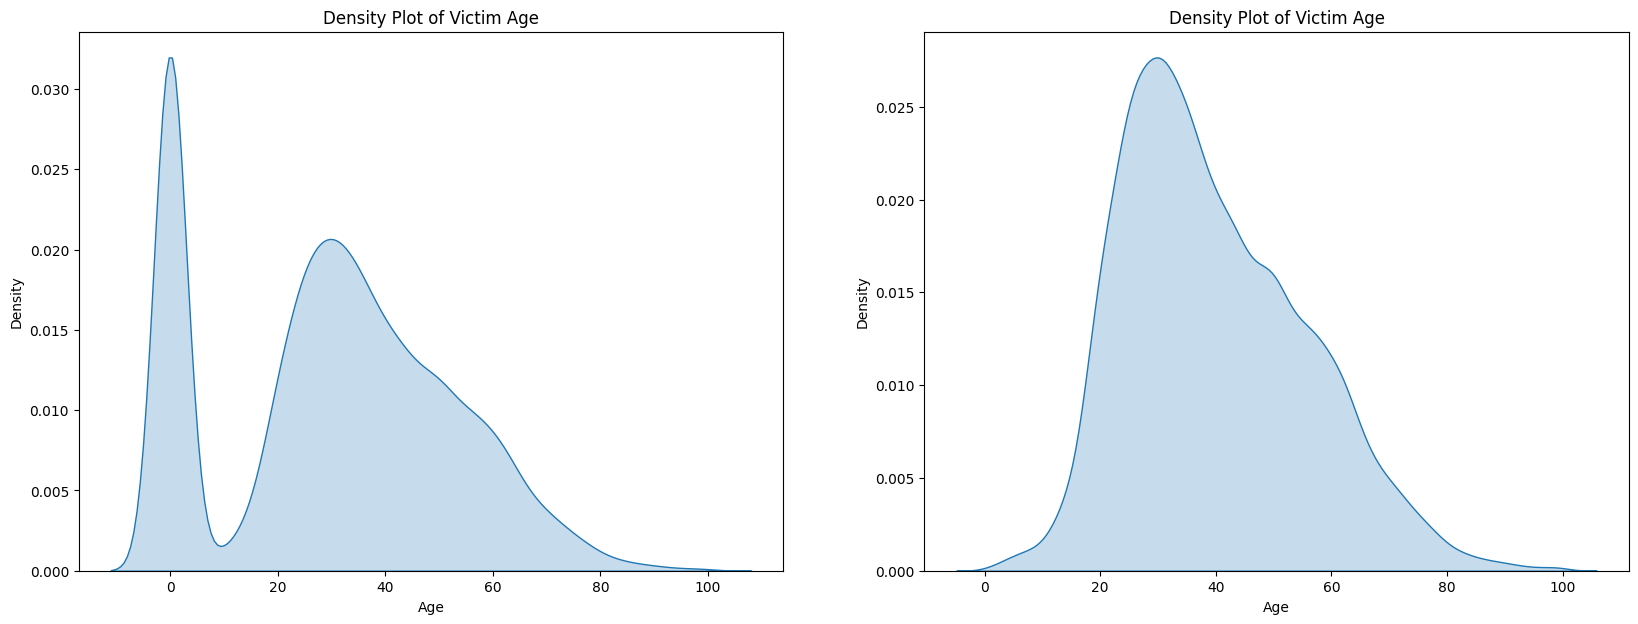

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(20, 7))

sns.kdeplot(data=train_data['Victim_Age'], shade=True, ax=axes[0])
axes[0].set_title('Density Plot of Victim Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')

sns.kdeplot(data=train_data['Victim_Age'].replace([-2, -1, 0], np.nan), shade=True, ax=axes[1])
axes[1].set_title('Density Plot of Victim Age')
axes[1].set_xlabel('Age')
axes[1].set_ylabel('Density')

plt.show()

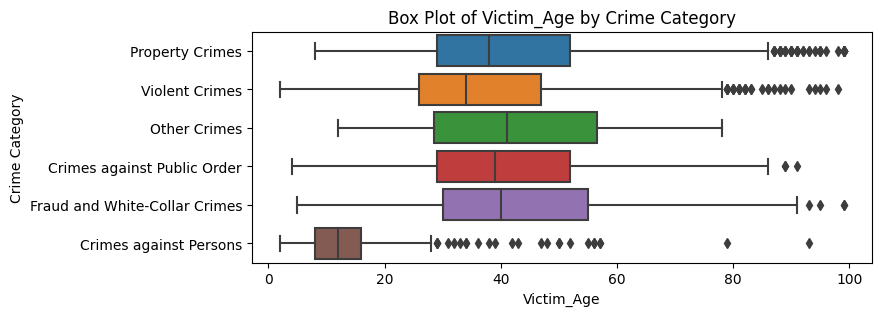

In [19]:
# Victim_Age vs Crime_Category boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(y='Crime_Category', x='Victim_Age',
            data=train_data[['Crime_Category', 
                             'Victim_Age']].replace([-2, -1, 0], np.nan),
            orient='h')
plt.title('Box Plot of Victim_Age by Crime Category')
plt.ylabel('Crime Category')
plt.xlabel('Victim_Age')
plt.show()

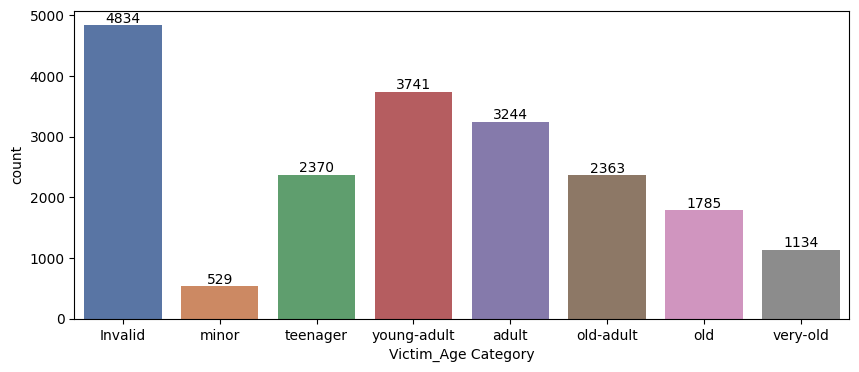

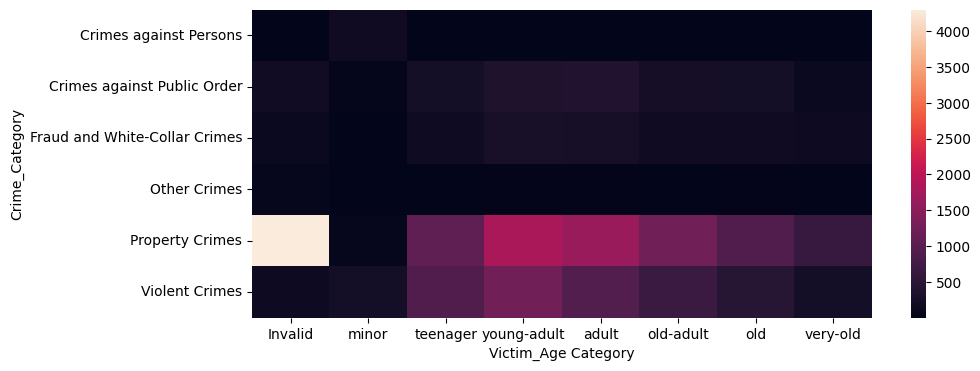

In [20]:
df = train_data.copy()
age_labels = {0:"Invalid", 1:"minor", 2:"teenager", 3:"young-adult", 4:"adult", 
                5:"old-adult", 6:"old", 7:"very-old"}
df['age_type'] = pd.cut(df['Victim_Age'], 
                        bins=[-3, 0, 17, 25, 34, 44, 54, 64, 120], 
                        labels=age_labels.values(), right=True) 
plt.figure(figsize=(10, 4))
ax = sns.countplot(df, x='age_type', palette='deep')
for container in ax.containers:
    ax.bar_label(container)
plt.xlabel('Victim_Age Category')
plt.show()

plt.figure(figsize=(10, 4))
sns.heatmap(df.groupby(['Crime_Category', 'age_type']).size().unstack(fill_value=0), 
           )
plt.xlabel('Victim_Age Category')
plt.show()

# Latitude & Longitude
Latitude and Longitude coordinates of the crime incident.

In [21]:
print(train_data[['Latitude', 'Longitude']].describe())
print("Correlation b/w Latitude and Longitude:",
      f'{np.corrcoef(train_data.Latitude, train_data.Longitude)[1, 0]:.2f}')

           Latitude     Longitude
count  20000.000000  20000.000000
mean      33.940704   -117.893072
std        2.126810      7.377726
min        0.000000   -118.663400
25%       34.009200   -118.429700
50%       34.058700   -118.323000
75%       34.165025   -118.274400
max       34.328100      0.000000
Correlation b/w Latitude and Longitude: -1.00


In [22]:
print(train_data[['Latitude', 
                  'Longitude']][(train_data.Latitude==0) | (train_data.Longitude==0)])

       Latitude  Longitude
344         0.0        0.0
416         0.0        0.0
430         0.0        0.0
631         0.0        0.0
855         0.0        0.0
...         ...        ...
18838       0.0        0.0
18995       0.0        0.0
19181       0.0        0.0
19190       0.0        0.0
19316       0.0        0.0

[78 rows x 2 columns]


(0, 0) Latitude and Longitude signify missing values because this location is in the Gulf of Guinea (South Atlantic Ocean) off the west African coast known as Null Island

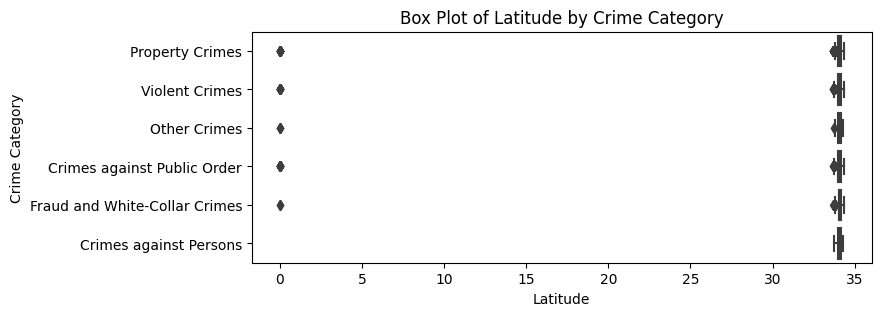

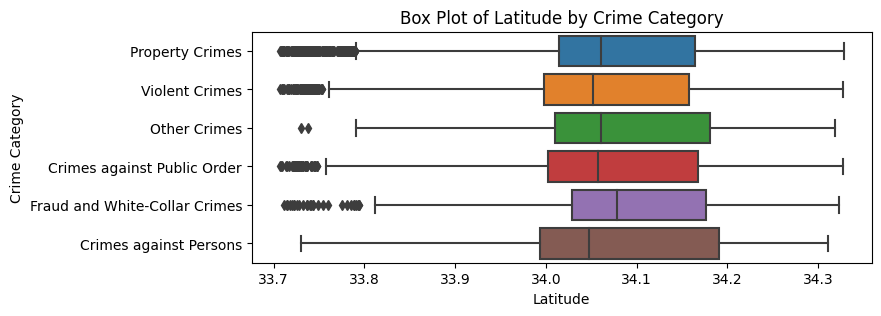

In [23]:
# Latitude vs Crime_Category boxplot
plt.figure(figsize=(8, 3))
sns.boxplot(y='Crime_Category', x='Latitude', 
            data=train_data[['Crime_Category', 'Latitude']], 
            orient='h')
plt.title('Box Plot of Latitude by Crime Category')
plt.ylabel('Crime Category')
plt.xlabel('Latitude')
plt.show()

plt.figure(figsize=(8, 3))
sns.boxplot(y='Crime_Category', x='Latitude', 
            data=train_data[['Crime_Category', 'Latitude']].replace(0, np.nan), 
            orient='h')
plt.title('Box Plot of Latitude by Crime Category')
plt.ylabel('Crime Category')
plt.xlabel('Latitude')
plt.show()

# Latitude vs Crime_Category boxplot
# plt.figure(figsize=(8, 3))
# sns.boxplot(y='Crime_Category', x='Longitude', 
#             data=train_data[['Crime_Category', 'Longitude']].replace(0, np.nan).dropna(), 
#             orient='h')
# plt.title('Box Plot of Longitude by Crime Category')
# plt.ylabel('Crime Category')
# plt.xlabel('Longitude')
# plt.show()

# Time_Occurred
Time the incident occurred in 24-hour military time.

In [24]:
# Time_Occurred description
print(train_data.Time_Occurred.describe())

count    20000.000000
mean      1352.380350
std        646.100291
min          1.000000
25%        930.000000
50%       1430.000000
75%       1900.000000
max       2359.000000
Name: Time_Occurred, dtype: float64


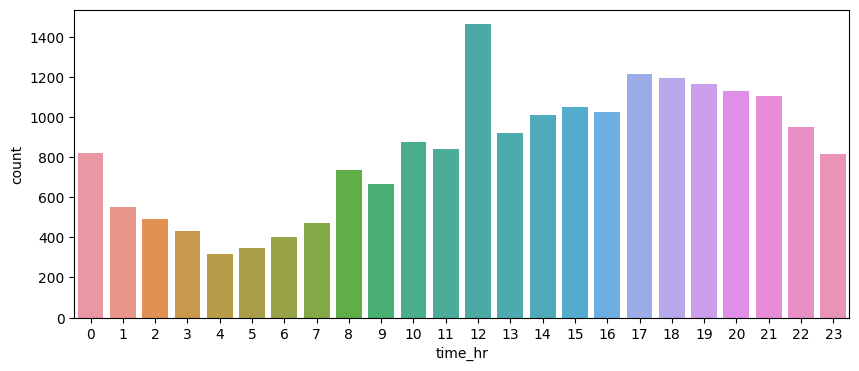

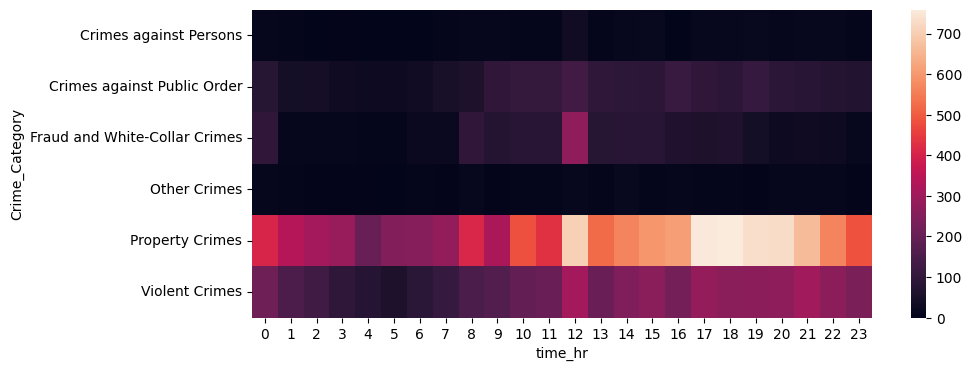

In [25]:
df = train_data.copy()
df['time_hr'] = df.Time_Occurred.apply(lambda x: int(x//100))
plt.figure(figsize=(10, 4))
sns.countplot(df, x='time_hr')
plt.xlabel('time_hr')
# plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(10, 4))
sns.heatmap(df.groupby(['Crime_Category', 'time_hr']).size().unstack(fill_value=0))
plt.xlabel('time_hr')
# plt.xticks(rotation=90)
plt.show()

# Victim_Sex
Gender of the victim.

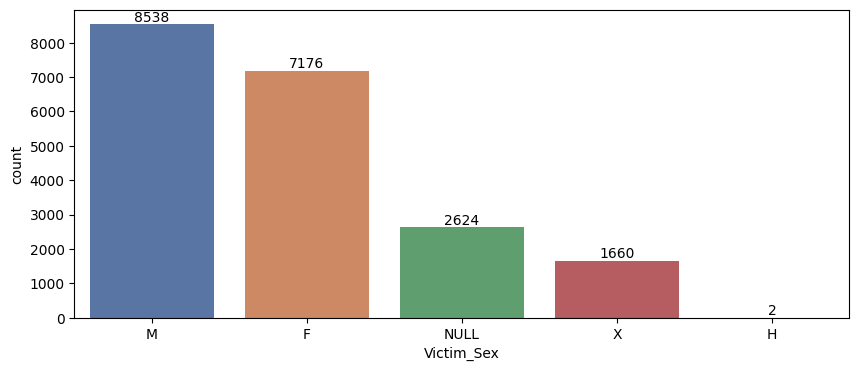

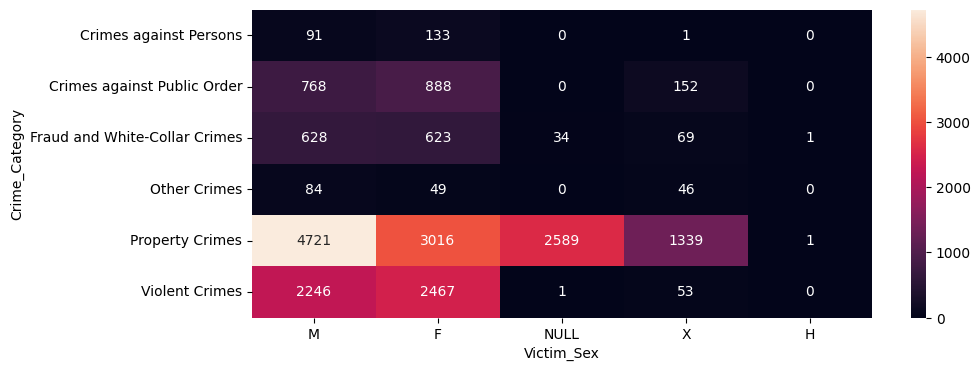

In [26]:
df = train_data.copy()

plt.figure(figsize=(10, 4))
ax = sns.countplot(df.fillna('NULL'), x='Victim_Sex', 
             order=df.Victim_Sex.fillna('NULL').value_counts().index, 
             palette='deep') 
for container in ax.containers:
    ax.bar_label(container)    
plt.show()

plt.figure(figsize=(10, 4))
group = df.fillna('NULL').groupby(['Crime_Category', 
                                   'Victim_Sex']).size().unstack(fill_value=0)
sns.heatmap(group.loc[:, df.Victim_Sex.fillna('NULL').value_counts().index], 
           annot=True, fmt='d')
plt.xlabel('Victim_Sex')
plt.show()

# Victim_Descent
Descent code of the victim.

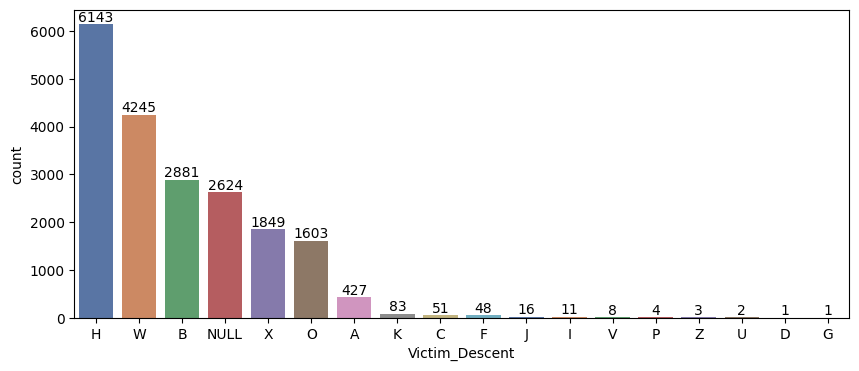

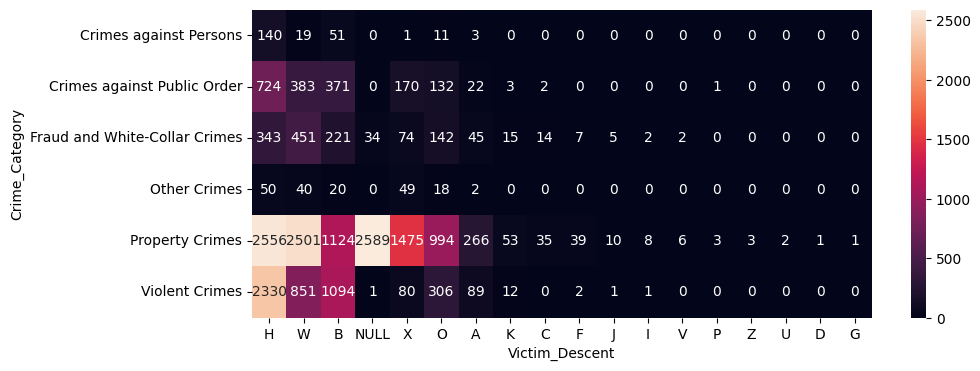

In [27]:
df = train_data.copy()

plt.figure(figsize=(10, 4))
ax = sns.countplot(df.fillna('NULL'), x='Victim_Descent', 
             order=df.Victim_Descent.fillna('NULL').value_counts().index, 
             palette='deep')
for container in ax.containers:
    ax.bar_label(container)
plt.show()

plt.figure(figsize=(10, 4))
group = df.fillna('NULL').groupby(['Crime_Category', 
                                   'Victim_Descent']).size().unstack(fill_value=0)
sns.heatmap(group.loc[:, df.Victim_Descent.fillna('NULL').value_counts().index], 
           annot=True, fmt='d')
plt.xlabel('Victim_Descent')
plt.show()

# Part 1-2
Crime classification.

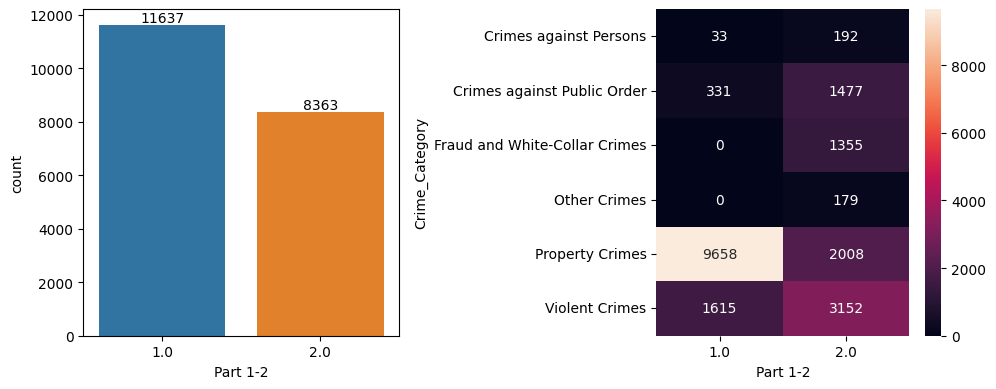

In [28]:
df = train_data.copy()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Horizontal Bar Chart
sns.countplot(df, x='Part 1-2', 
              order=train_data['Part 1-2'].value_counts().index,
              ax=axs[0]
              )
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d')
# # axs[0].spines['right'].set_visible(False)
# axs[0].spines['top'].set_visible(False)

group = df.groupby(['Crime_Category', 'Part 1-2']).size().unstack(fill_value=0)
sns.heatmap(group.loc[:, train_data['Part 1-2'].value_counts().index], 
            annot=True, fmt="d", ax=axs[1])

plt.tight_layout()
plt.show()

# Status
Status of the case.

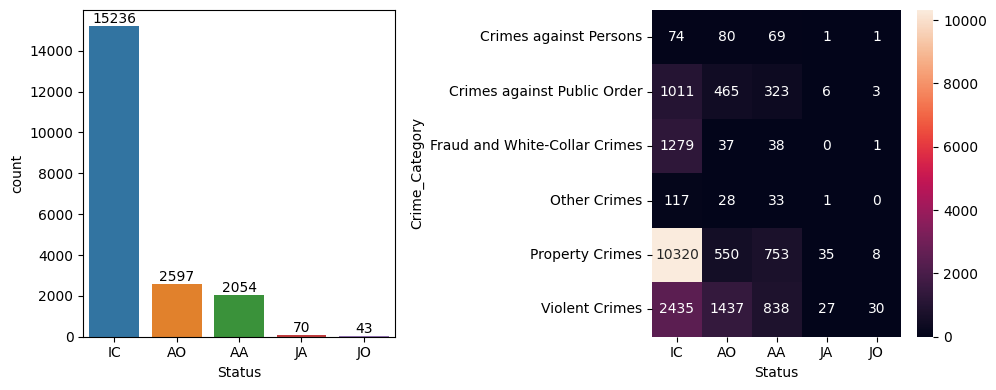

In [29]:
df = train_data.copy()
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Horizontal Bar Chart
sns.countplot(df, x='Status', 
              order=train_data['Status'].value_counts().index,
              ax=axs[0]
              )
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d')
# axs[0].spines['right'].set_visible(False)
# axs[0].spines['top'].set_visible(False)

group = df.groupby(['Crime_Category', 'Status']).size().unstack(fill_value=0)
sns.heatmap(group.loc[:, train_data['Status'].value_counts().index], 
            annot=True, fmt="d", ax=axs[1])

plt.tight_layout()
plt.show()

# Weapon_Used_Code
Weapon code indicating the type of weapon used.

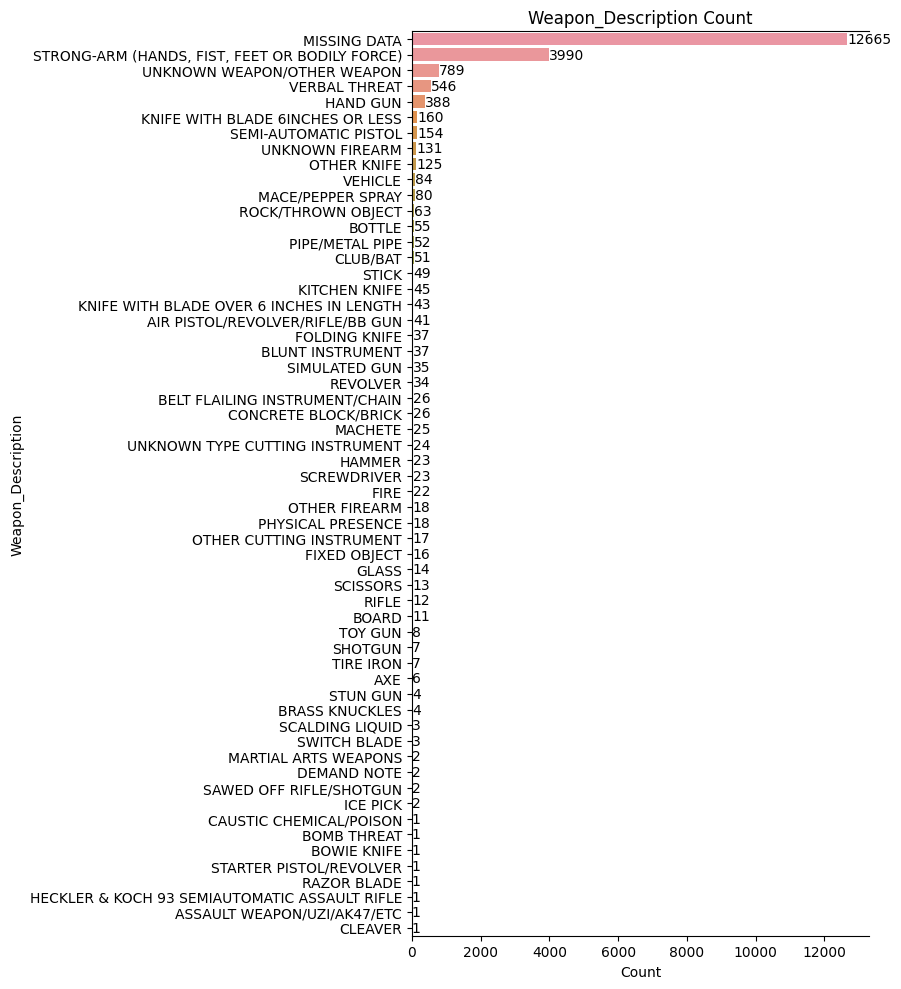

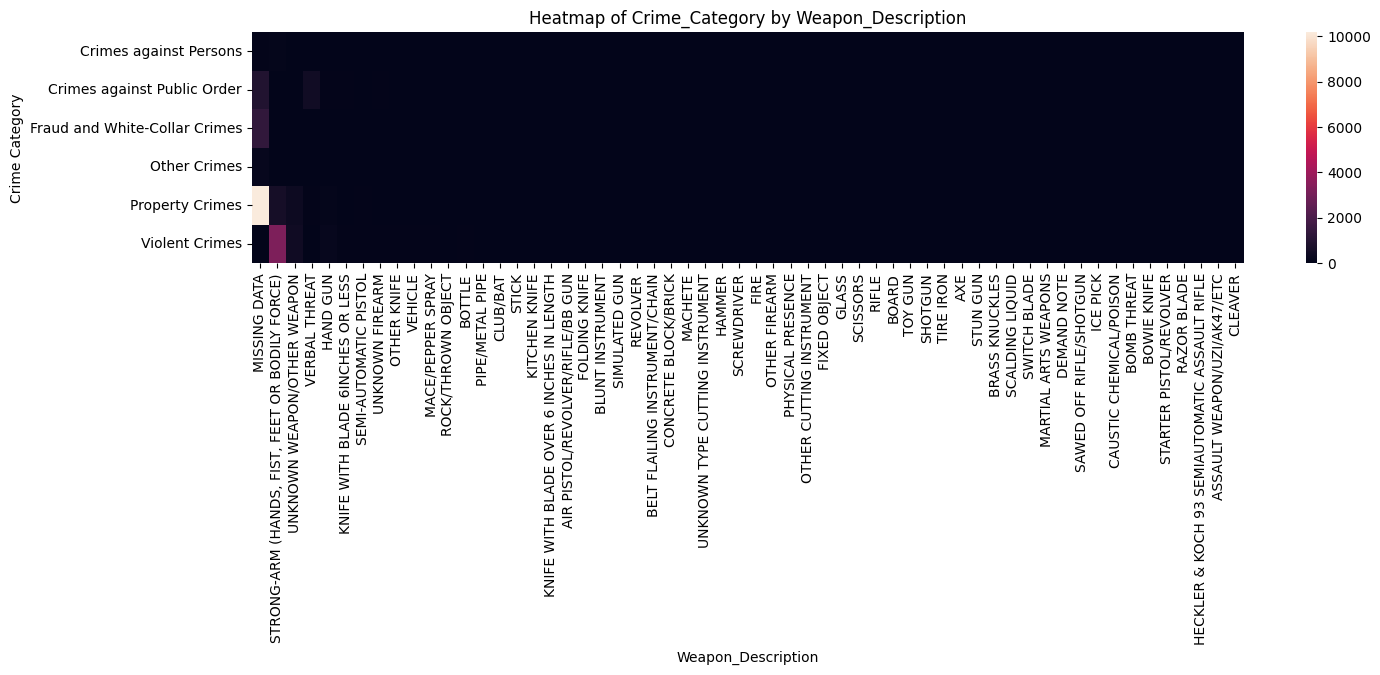

In [30]:
grouped = train_data.fillna("MISSING DATA").groupby(['Crime_Category', 
                              'Weapon_Description']).size().unstack(fill_value=0)

plt.figure(figsize=(9, 10))
ax = sns.countplot(data=train_data.fillna("MISSING DATA"), y="Weapon_Description", 
              order=train_data['Weapon_Description'].fillna("MISSING DATA").value_counts().index)
for container in ax.containers:
    ax.bar_label(container)
plt.title(f'Weapon_Description Count')
plt.xlabel('Count')
plt.ylabel('Weapon_Description')
plt.tight_layout()
plt.gca().spines['right'].set_visible(False)
plt.show()

# heat map with Crime Category
plt.figure(figsize=(16, 3))
sns.heatmap(grouped.loc[:, train_data['Weapon_Description'].fillna("MISSING DATA").value_counts().index], 
            annot=False, fmt="d")
plt.title('Heatmap of Crime_Category by Weapon_Description')
plt.ylabel('Crime Category')
plt.xlabel('Weapon_Description')
plt.show()

# Date_Occurred

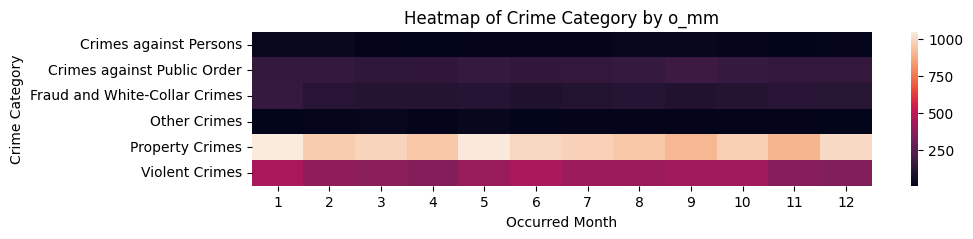

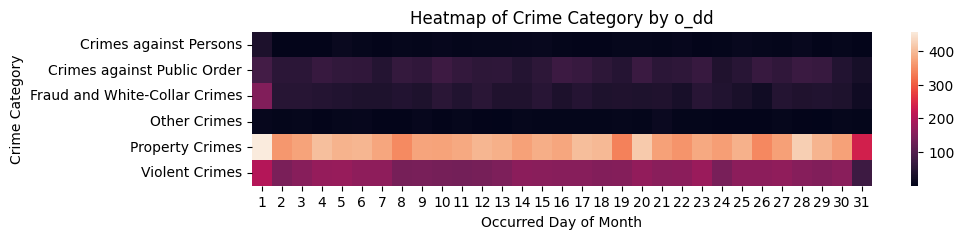

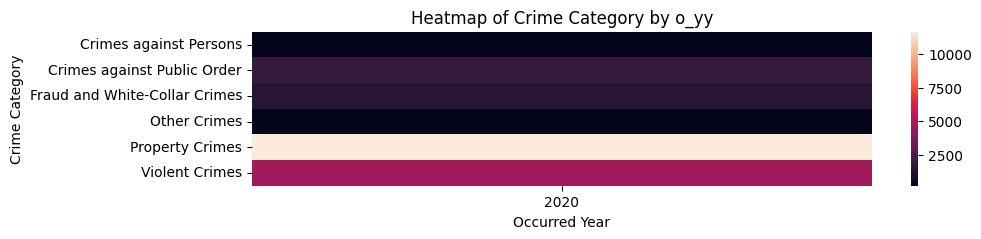

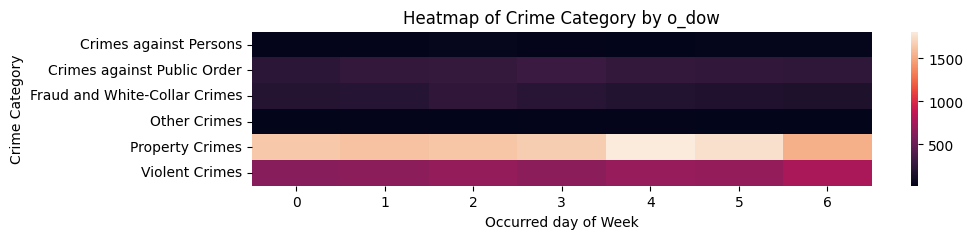

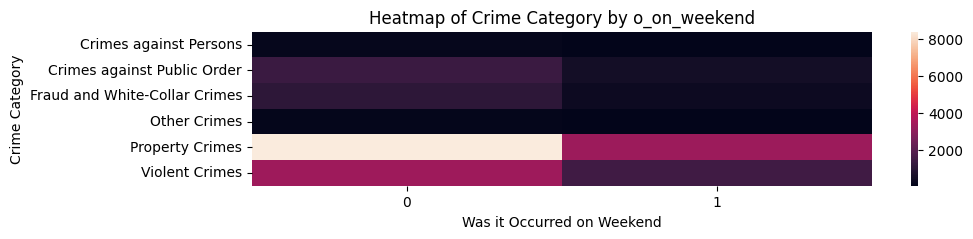

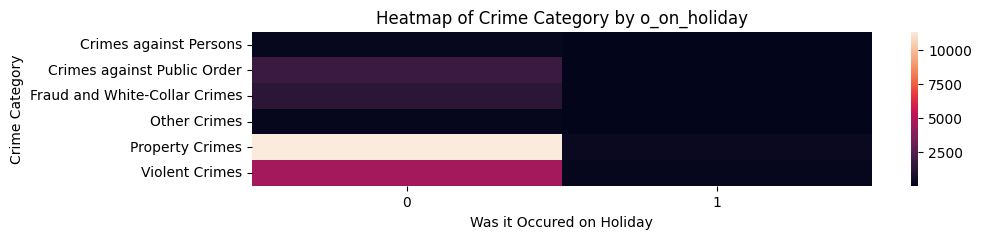

In [31]:
df = train_data.copy()
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start=df.Date_Occurred.min(), end=df.Date_Reported.max())

# Occurred Month Day and Year DayOfWeek, was on weekend and was on holiday
df = df.assign(o_mm=df.Date_Occurred.dt.month, 
               o_dd=df.Date_Occurred.dt.day, 
               o_yy=df.Date_Occurred.dt.year, 
               o_dow=df.Date_Occurred.dt.dayofweek,
               o_on_weekend=df.Date_Occurred.dt.dayofweek.apply(lambda x: 0 if x<5 else 1),
               o_on_holiday=df.Date_Occurred.isin(holidays).apply(lambda x: 1 if x else 0)
              )
Occurred_dict = {'o_mm': 'Occurred Month',
                'o_dd': 'Occurred Day of Month',
                'o_yy': 'Occurred Year', 
                'o_dow': 'Occurred day of Week',
                'o_on_weekend': 'Was it Occurred on Weekend',
                'o_on_holiday': 'Was it Occured on Holiday'}
for feat in ['o_mm', 'o_dd', 'o_yy', 'o_dow', 'o_on_weekend', 'o_on_holiday']:
    grouped = df.groupby(['Crime_Category', feat]).size().unstack(fill_value=0)
    plt.figure(figsize=(10, 2))
    sns.heatmap(grouped, annot=False, fmt="d")
    plt.title(f'Heatmap of Crime Category by {feat}')
    plt.ylabel('Crime Category')
    plt.xlabel(f'{Occurred_dict[feat]}')
    plt.show()

# Date_Reported

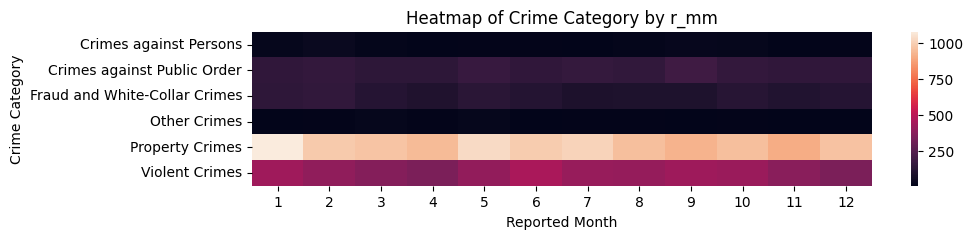

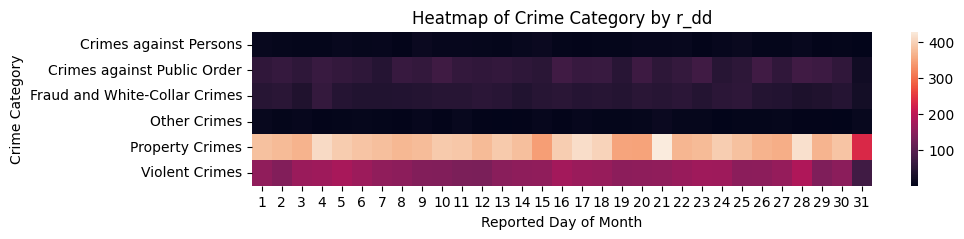

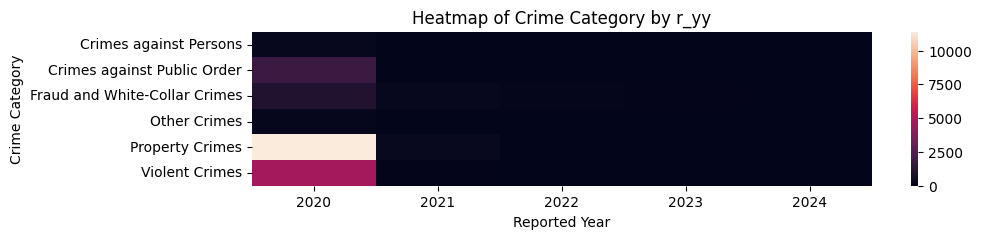

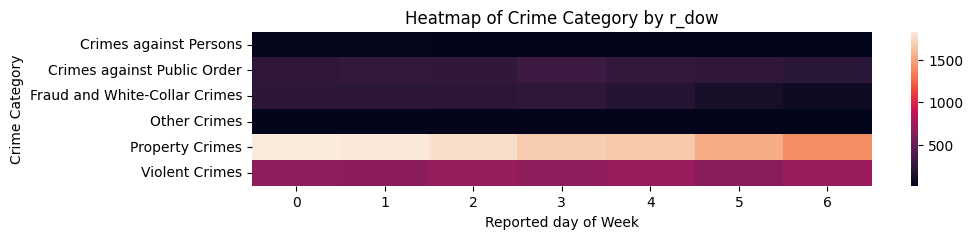

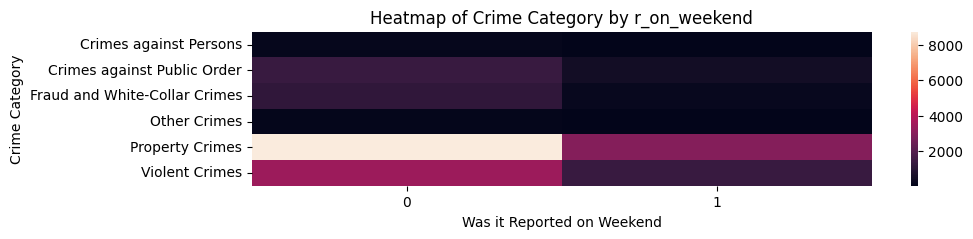

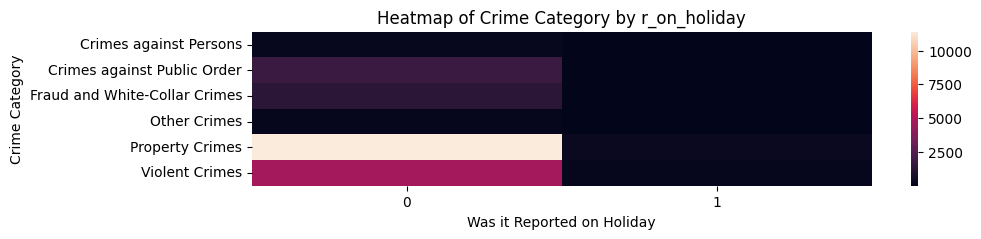

In [32]:
# Reported Month Day and Year DayOfWeek, was on weekend and was on holiday
df = df.assign(r_mm=df.Date_Reported.dt.month, 
               r_dd=df.Date_Reported.dt.day, 
               r_yy=df.Date_Reported.dt.year, 
               r_dow=df.Date_Reported.dt.dayofweek,
               r_on_weekend=df.Date_Reported.dt.dayofweek.apply(lambda x: 0 if x<5 else 1),
               r_on_holiday=df.Date_Reported.isin(holidays).apply(lambda x: 1 if x else 0)
              )
Reported_dict = {'r_mm': 'Reported Month',
                'r_dd': 'Reported Day of Month',
                'r_yy': 'Reported Year', 
                'r_dow': 'Reported day of Week',
                'r_on_weekend': 'Was it Reported on Weekend',
                'r_on_holiday': 'Was it Reported on Holiday'}
for feat in ['r_mm', 'r_dd', 'r_yy', 'r_dow', 'r_on_weekend', 'r_on_holiday']:
    grouped = df.groupby(['Crime_Category', feat]).size().unstack(fill_value=0)
    plt.figure(figsize=(10, 2))
    sns.heatmap(grouped, annot=False, fmt="d")
    plt.title(f'Heatmap of Crime Category by {feat}')
    plt.ylabel('Crime Category')
    plt.xlabel(f'{Reported_dict[feat]}')
    plt.show()

# Delay in Reporting

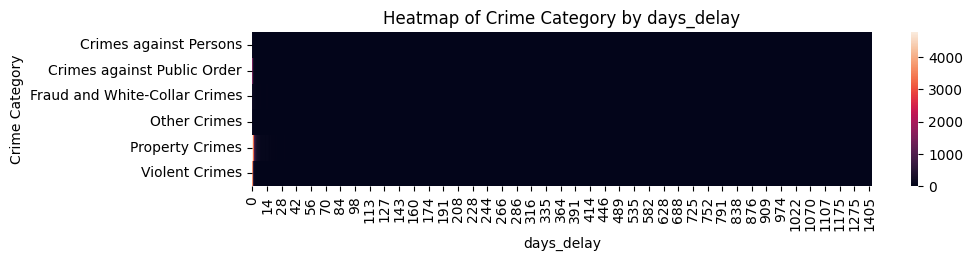

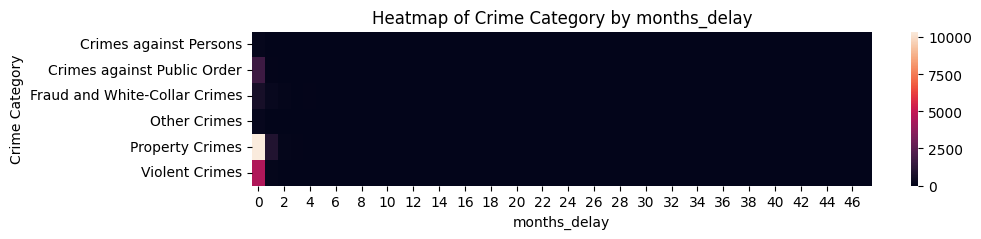

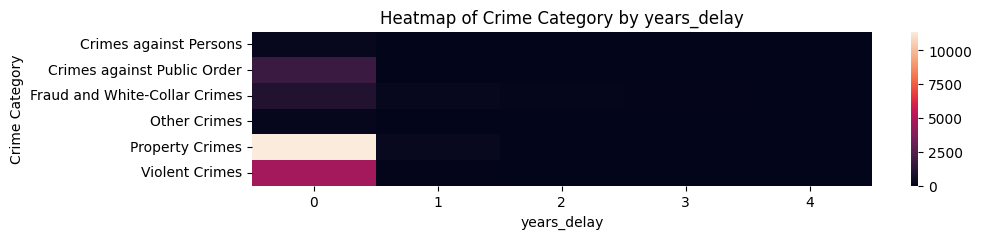

In [33]:
df = df.assign(days_delay=(df.Date_Reported - df.Date_Occurred).dt.days,
               months_delay=(df.r_yy - df.o_yy) * 12 + (df.r_mm - df.o_mm),
               years_delay=df.r_yy - df.o_yy 
              )
for feat in ['days_delay', 'months_delay', 'years_delay']:
    grouped = df.groupby(['Crime_Category', feat]).size().unstack(fill_value=0)
    plt.figure(figsize=(10, 2))
    sns.heatmap(grouped, annot=False, fmt="d")
    plt.title(f'Heatmap of Crime Category by {feat}')
    plt.ylabel('Crime Category')
    plt.xlabel(f'{feat}')
    plt.show()

## Feature Engineering

In [34]:
def feature_engineering(df, cols):
  df['age_missing'] = df.Victim_Age.isin([0]).apply(lambda x: 1 if x else 0)
  df['Victim_Age'] = df['Victim_Age'].replace([-2, -1, 0], np.nan)
  df['Latitude'] = df['Latitude'].replace([0], np.nan)
  df['loc_type'] = df.Location.apply(lambda x: re.split(r'\s{2,}', x)[-1]).apply(lambda x: x if len(x)==2 else np.nan)
  # df['time_hr'] = df.Time_Occurred.astype('int').apply(lambda x: x//100)
  
  df['days_delay'] = (df.Date_Reported - df.Date_Occurred).dt.days
  # df['months_delay'] = (df.Date_Reported.dt.year - df.Date_Occurred.dt.year) * 12 + (df['Date_Reported'].dt.month - df['Date_Occurred'].dt.month)
  # df['years_delay'] = df.Date_Reported.dt.year - df.Date_Occurred.dt.year

  cal = USFederalHolidayCalendar()
  holidays = cal.holidays(start=df['Date_Occurred'].min(), end=df['Date_Reported'].max())

  df['o_holiday'] = df['Date_Occurred'].isin(holidays).apply(lambda x: 1 if x else 0)

  return df.drop(cols, axis=1)

# 0) Preprocessing

## Splitting and Baseline

In [35]:
# Encoding the Crime_Category
le = LabelEncoder()
y = le.fit_transform(train_data.Crime_Category)
X_train_data, X_val_data, y_train, y_val = train_test_split(train_data.drop('Crime_Category', axis=1), y,
                                                            test_size=0.2, stratify=y,
                                                            random_state=42)

# Baseline
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X_train_data, y_train)
print('Baseline Accuracy Score:', f'{dc.score(X_train_data, y_train)*100:.2f}%')

Baseline Accuracy Score: 58.33%


## Stratified3Fold Cross Validation

In [36]:
# check model performance
def check(model):
    print('train_accuracy_score'.ljust(30, ' '), f'{model.score(X_train, y_train):.3f}')
    print('valid_accuracy_score'.ljust(30, ' '), f'{model.score(X_val, y_val):.3f}')
#     print(classification_report(y_val, model.predict(X_val), target_names=le.classes_))

# 3 fold Cross Validation to cross check train score
def cross_check(model):
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf)
    print('Stratified3Fold_mean'.ljust(30, ' '), f'{scores.mean():.3f}')
    print('Stratified3Fold_std'.ljust(30, ' '), f'{scores.std():.3f}')
    print('valid_accuracy_score'.ljust(30, ' '), f'{model.score(X_val, y_val):.3f}')
    
    # classification report and confusion matrix
    y_val_pl = model.predict(X_val)
    
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))
    report = classification_report(y_val, y_val_pl, output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=axes[0])
    axes[0].tick_params(axis='y', rotation=0)

    cm = confusion_matrix(y_val, y_val_pl)
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[1])
    axes[1].tick_params(axis='y', rotation=0)
    plt.show()
    print(dict(zip(le.transform(le.classes_), le.classes_)))

In [37]:
def check_auc(model, roc=False, pr=False):
    result = {'Classifier': (model.predict(X_val), model.predict_proba(X_val))}
    if roc:
        fig, axes = plt.subplots(2, 3, figsize=(20, 10))
        print("Area Under Curve (ROC)".center(105, "="))
        for i, crime in (dict(zip(le.transform(le.classes_), le.classes_))).items():
          for j, (model, y_val_p) in enumerate(result.items()):
            fpr, tpr, thresholds = roc_curve(label_binarize(y_val, classes=np.unique(y_val))[:, i],
                                             y_val_p[1][:, i])
            roc_auc = auc(fpr, tpr)
            axes[i//3, i%3].plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model, roc_auc))
            axes[i//3, i%3].plot([0, 1], [0, 1], 'k--')
            axes[i//3, i%3].set_title(crime)
            axes[i//3, i%3].set_ylabel('True Positive Rate')
            axes[i//3, i%3].set_xlabel('False Positive Rate')
            axes[i//3, i%3].legend(loc="lower right")
        plt.show()
    if pr:
        # Precision-Recall Curve
        fig, axes = plt.subplots(2, 3, figsize=(20, 10))
        print("Area Under Curve (PR)".center(105, "="))
        for i, crime in (dict(zip(le.transform(le.classes_), le.classes_))).items():
          for j, (name, y_val_p) in enumerate(result.items()):
            precision, recall, thresholds = precision_recall_curve(label_binarize(y_val, classes=np.unique(y_val))[:, i],
                                                                  y_val_p[1][:, i])
            pc_auc = auc(recall, precision)
            axes[i//3, i%3].plot(recall, precision, label='%s PR curve (area = %0.2f)' % (name, pc_auc))
            axes[i//3, i%3].set_title(crime)
            axes[i//3, i%3].set_xlabel('Recall')
            axes[i//3, i%3].set_ylabel('Precision')
            axes[i//3, i%3].legend(loc="lower left")
        plt.show()

# Pipeline

In [38]:
tf0 =  FunctionTransformer(feature_engineering, 
                           kw_args={'cols' : [
                                             'Area_Name', 'Premise_Description', 'Weapon_Description', 'Status_Description', 
                                             'Cross_Street', 'Location', 'Date_Occurred', 'Date_Reported', 
                                             'Longitude',  
                                                              ]})
tf1 = ColumnTransformer([
                         ('imp0', SimpleImputer(strategy='constant',
                                                fill_value='ST'), ['loc_type']),
                         ('imp1', SimpleImputer(strategy='constant',
                                                fill_value=0),["Weapon_Used_Code"]),
                         ('imp6', SimpleImputer(strategy='constant',
                                                fill_value=34),['Latitude']),
                         ('imp2', SimpleImputer(strategy='constant',
                                                fill_value='X'),["Victim_Sex"]),
                         ('imp3', SimpleImputer(strategy='constant',
                                                fill_value='X'),["Victim_Descent"]),
                         ('imp4', SimpleImputer(strategy='constant',
                                                fill_value="mo_null"), ['Modus_Operandi']),
                         ('imp5', SimpleImputer(strategy='constant',
                                                fill_value=20), ['Victim_Age']),                         
                        ],
                        remainder='passthrough', verbose_feature_names_out=0).set_output(transform='pandas')
tf2 = ColumnTransformer([
                         ('scl1', MinMaxScaler(), ['Victim_Age', 'Latitude', 'Time_Occurred', 'Premise_Code', 'Reporting_District_no', ]),
                         ('enc1', OneHotEncoder(sparse_output=False,
                                                handle_unknown='ignore'),
                                                 [
                                                  'Victim_Descent',  'Victim_Sex', 'Status',
                                                   'Area_ID',
                                                  
                                                  'loc_type', 
                                                  "Weapon_Used_Code",
                                                  ]),
                        ],remainder='passthrough', verbose_feature_names_out=0).set_output(transform='pandas')

tf3 = ColumnTransformer([('mo', Pipeline([('vect', CountVectorizer())]), 'Modus_Operandi')], 
                        remainder='passthrough',verbose_feature_names_out=0)
pipe = Pipeline([('tf0', tf0), ('tf1',tf1), ('tf2',tf2), ('tf3', tf3)])

X_train = pipe.fit_transform(X_train_data, y_train)
X_val = pipe.transform(X_val_data)
print('Train Valid Shape:    ', X_train.shape, X_val.shape)
pipe

Train Valid Shape:     (16000, 586) (4000, 586)


Pipeline(steps=[('tf0',
                 FunctionTransformer(func=<function feature_engineering at 0x7b58e29409d0>,
                                     kw_args={'cols': ['Area_Name',
                                                       'Premise_Description',
                                                       'Weapon_Description',
                                                       'Status_Description',
                                                       'Cross_Street',
                                                       'Location',
                                                       'Date_Occurred',
                                                       'Date_Reported',
                                                       'Longitude']})),
                ('tf1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('imp0',
                                                  SimpleImputer(fill...
                                                   'Reporting_District_no']),
                                                 ('enc1',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Victim_Descent',
                                                   'Victim_Sex', 'Status',
                                                   'Area_ID', 'loc_type',
                                                   'Weapon_Used_Code'])],
                                   verbose_feature_names_out=0)),
                ('tf3',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('mo',
                                                  Pipeline(steps=[('vect',
                                                                   CountVectorizer())]),
                                                  'Modus_Operandi')],
                                   verbose_feature_names_out=0))])

In [39]:
for i, v in enumerate(sorted(pipe[-3].get_feature_names_out().tolist())):
    print(i, v)
final_df = pd.DataFrame(X_train.toarray(), columns=pipe[-1].get_feature_names_out())
for c in final_df.columns:
    if final_df[c].isna().sum()!=0:
        print(c)

0 Area_ID
1 Latitude
2 Modus_Operandi
3 Part 1-2
4 Premise_Code
5 Reporting_District_no
6 Status
7 Time_Occurred
8 Victim_Age
9 Victim_Descent
10 Victim_Sex
11 Weapon_Used_Code
12 age_missing
13 days_delay
14 loc_type
15 o_holiday


# 1) Logistic Regression

In [40]:
lr = LogisticRegression(random_state=42,)
lr.fit(X_train, y_train)
check(lr)

train_accuracy_score           0.874
valid_accuracy_score           0.876


Stratified3Fold_mean           0.866
Stratified3Fold_std            0.024
valid_accuracy_score           0.876


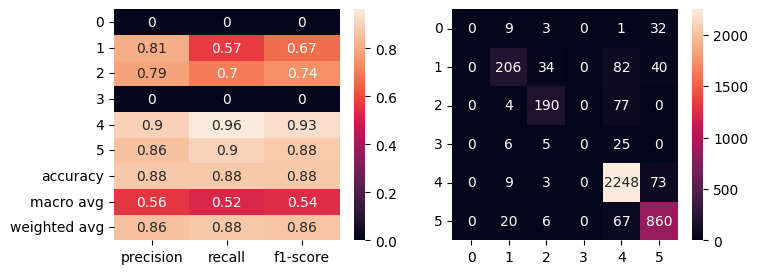

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [41]:
# params = {
#     'penalty': ['elasticnet', 'l2', 'l1', None],
#     'C': [1, 10, 50, 100],
#     'l1_ratio': [0, 0.25, 0.5, 0.75, 1]
# }

# hpt = GridSearchCV(lr, params, cv=2, n_jobs=-1, verbose=1,)
# hpt.fit(X_train, y_train)
# hpt.best_params_

lr_p = {'C': 1, 'l1_ratio': 0, 'penalty': 'l2'}
lr = LogisticRegression(random_state=42, **lr_p)
lr.fit(X_train, y_train)
cross_check(lr)

==========================================Area Under Curve (ROC)=========================================


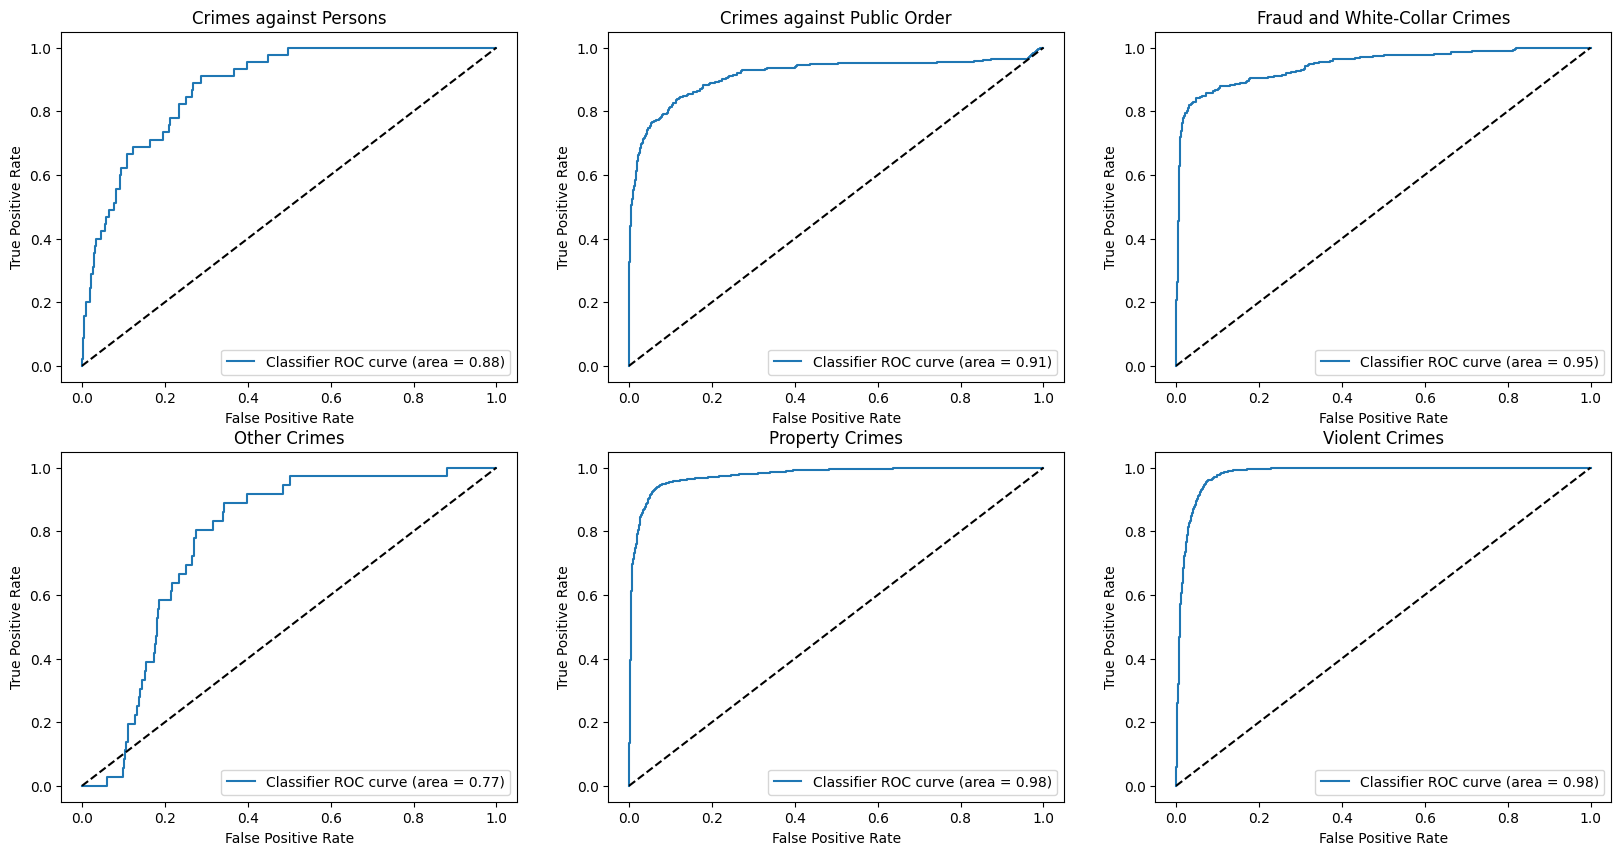

In [42]:
check_auc(lr, pr=0, roc=1)

## Model Attributes

In [43]:
print('no of features in                ', lr.n_features_in_)
print('coefficents for each class       ', lr.coef_.shape)
print('Constant intercept for each class', lr.intercept_.shape)

no of features in                 586
coefficents for each class        (6, 586)
Constant intercept for each class (6,)


# 2) KNN

In [44]:
knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
check(knc)

train_accuracy_score           0.907
valid_accuracy_score           0.868


Stratified3Fold_mean           0.871
Stratified3Fold_std            0.005
valid_accuracy_score           0.879


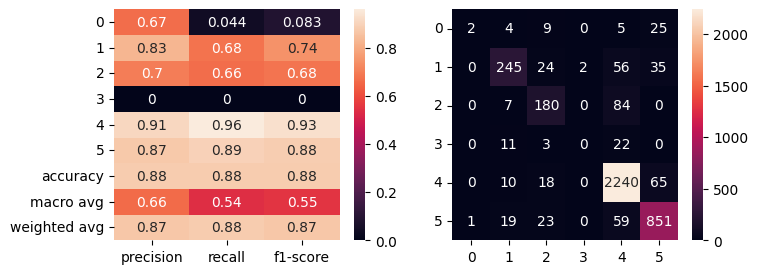

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [45]:
# params = {
#     'n_neighbors': range(3, 8, 2),
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2, 3],
#     'metric': ['chebyshev', 'minkowski']
# }

# hpt = GridSearchCV(knc, params, cv=2, n_jobs=-1, verbose=1)
# hpt.fit(X_train, y_train)
# hpt.best_params_

knc_p = {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
knc = KNeighborsClassifier(**knc_p)
knc.fit(X_train, y_train)
cross_check(knc)

## Model Inspection

In [46]:
print('Number of samples in the fitted', knc.n_samples_fit_)
print('Shape of train data            ', *X_train.shape)

Number of samples in the fitted 16000
Shape of train data             16000 586


# 3) SVM

In [47]:
svc = SVC(random_state=42)
svc.fit(X_train, y_train)
check(svc)

train_accuracy_score           0.758
valid_accuracy_score           0.762


In [48]:
# params = {
#     'C': [1, 5, 10, 100],
#     'kernel': ['poly', 'rbf'],
#     'degree': [2, 3, 4],
# }

# hpt = GridSearchCV(svc, params, cv=2, n_jobs=-1, verbose=1)
# hpt.fit(X_train, y_train)
# hpt.best_params_

svc_p = {'C': 100, 'degree': 2, 'kernel': 'rbf'}
svc = SVC(random_state=42, **svc_p)
svc.fit(X_train, y_train)
check(svc)

train_accuracy_score           0.929
valid_accuracy_score           0.926


Stratified3Fold_mean           0.919
Stratified3Fold_std            0.003
valid_accuracy_score           0.926


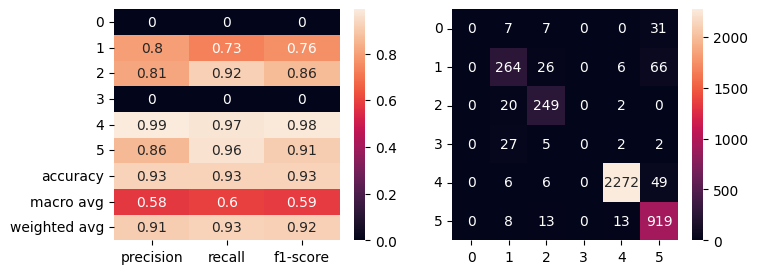

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [49]:
cross_check(svc)

## Model Attributes

In [50]:
print('Number of Support Vectors in each class', svc.n_support_)

Number of Support Vectors in each class [ 180  944  688  143 1473 1230]


# 4) DTree

In [51]:
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
check(dtc)

train_accuracy_score           1.000
valid_accuracy_score           0.944


In [52]:
# params = {
#     'ccp_alpha': [0.001, 0.01, 0.1],
#     'max_depth': [10, 20, 30, 40, 50],
#     'criterion': ['gini', 'entropy'],
#     'splitter': ['best', 'random'],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': [None, 'auto', 'sqrt', 'log2'],
#     'class_weight': [None, 'balanced']
# }
# hpt = GridSearchCV(dtc, params, cv=2, n_jobs=-1, verbose=1)
# hpt.fit(X_train, y_train)
# hpt.best_params_

## Hypertuned Parameter Model

Stratified3Fold_mean           0.935
Stratified3Fold_std            0.003
valid_accuracy_score           0.940


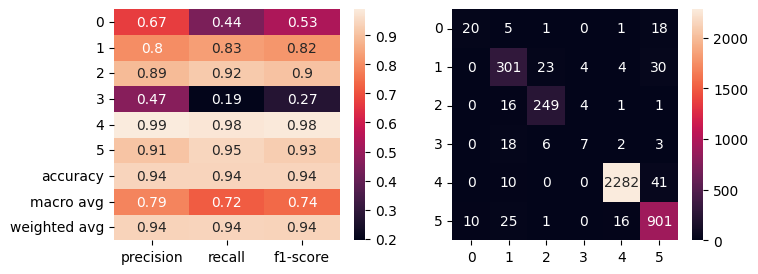

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [53]:
dtc_p = {'ccp_alpha': 0.001,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': 40,
 'max_features': None,
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'splitter': 'random'}
dtc = DecisionTreeClassifier(random_state=42, **dtc_p)
dtc.fit(X_train, y_train)
cross_check(dtc)

==========================================Area Under Curve (ROC)=========================================


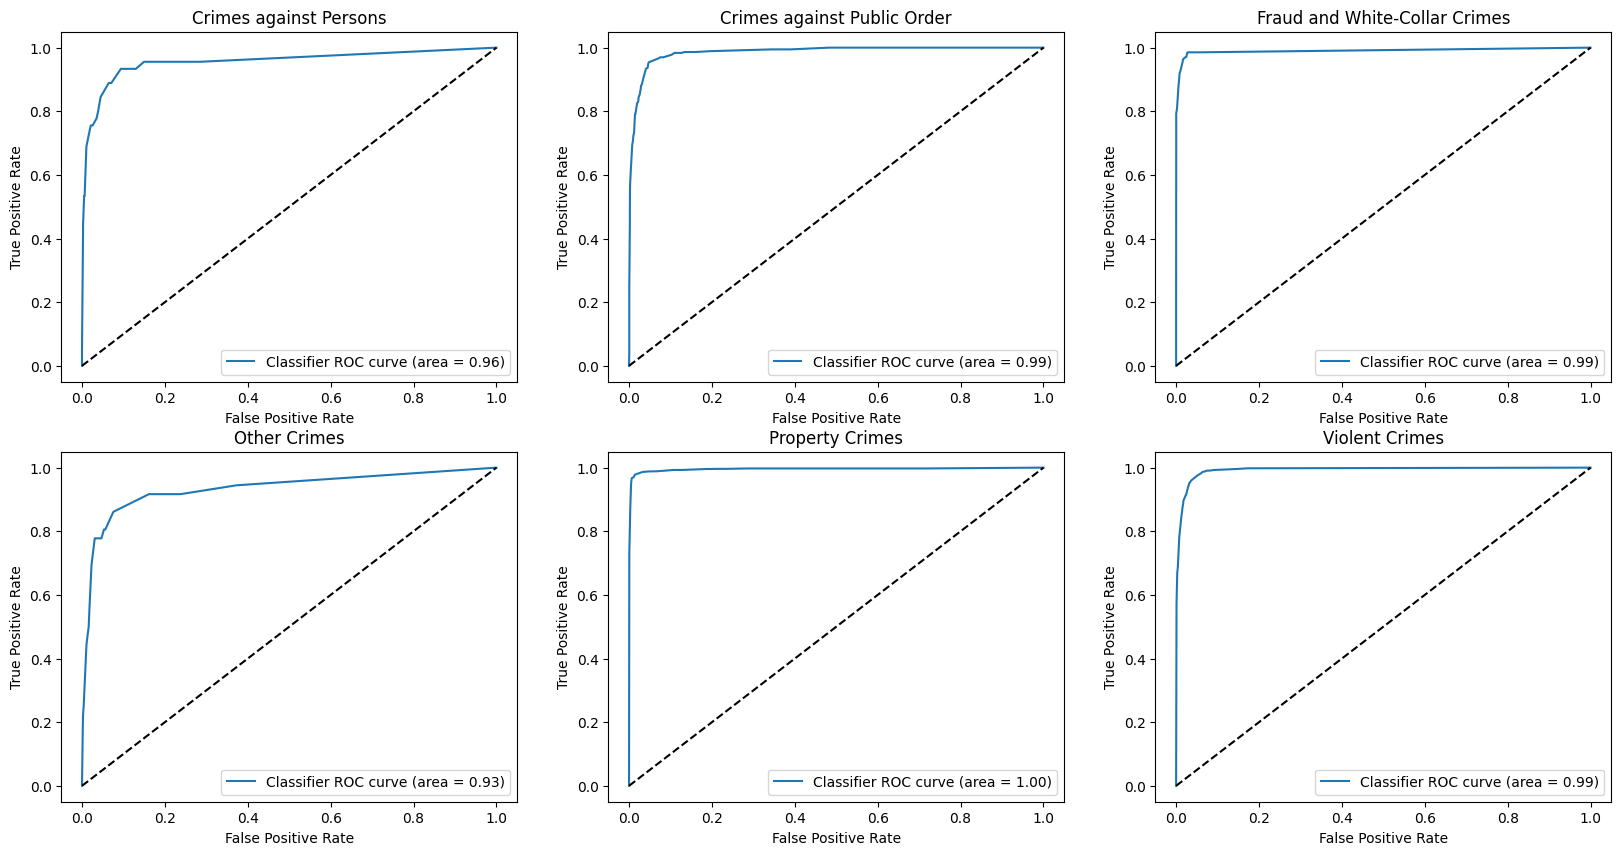

In [54]:
check_auc(dtc, pr=0, roc=1)

## Model Tree

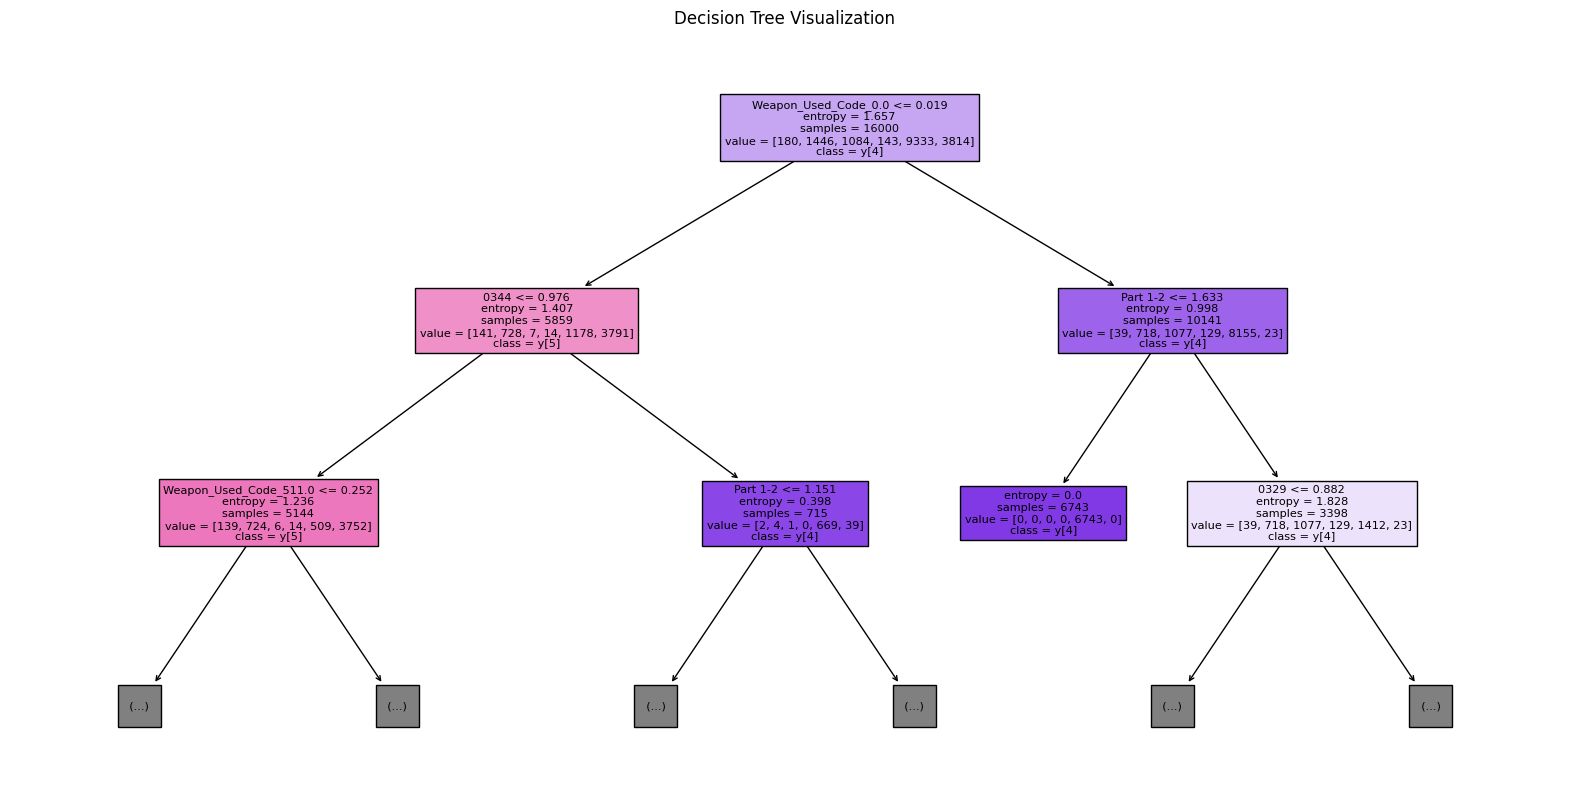

In [55]:
plt.figure(figsize=(20, 10))
plot_tree(dtc, filled=True, feature_names=pipe[-1].get_feature_names_out(), class_names=True, max_depth=2)
plt.title('Decision Tree Visualization')
plt.show()

* Modus Operandi, Part 1-2, Weapon_Used_Code are giving maximum information gain so being at the top nodes

# 5) Boosting

In [56]:
xgbc = xgbc = XGBClassifier(random_state=42, seed=42,                            
                   )
xgbc.fit(X_train, y_train)
check(xgbc)

train_accuracy_score           0.998
valid_accuracy_score           0.962


Stratified3Fold_mean           0.956
Stratified3Fold_std            0.003
valid_accuracy_score           0.962


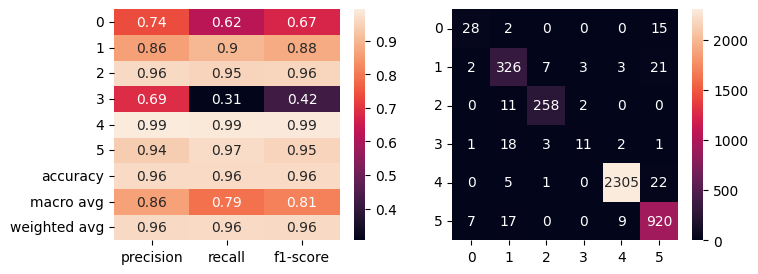

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [57]:
cross_check(xgbc)

==========================================Area Under Curve (ROC)=========================================


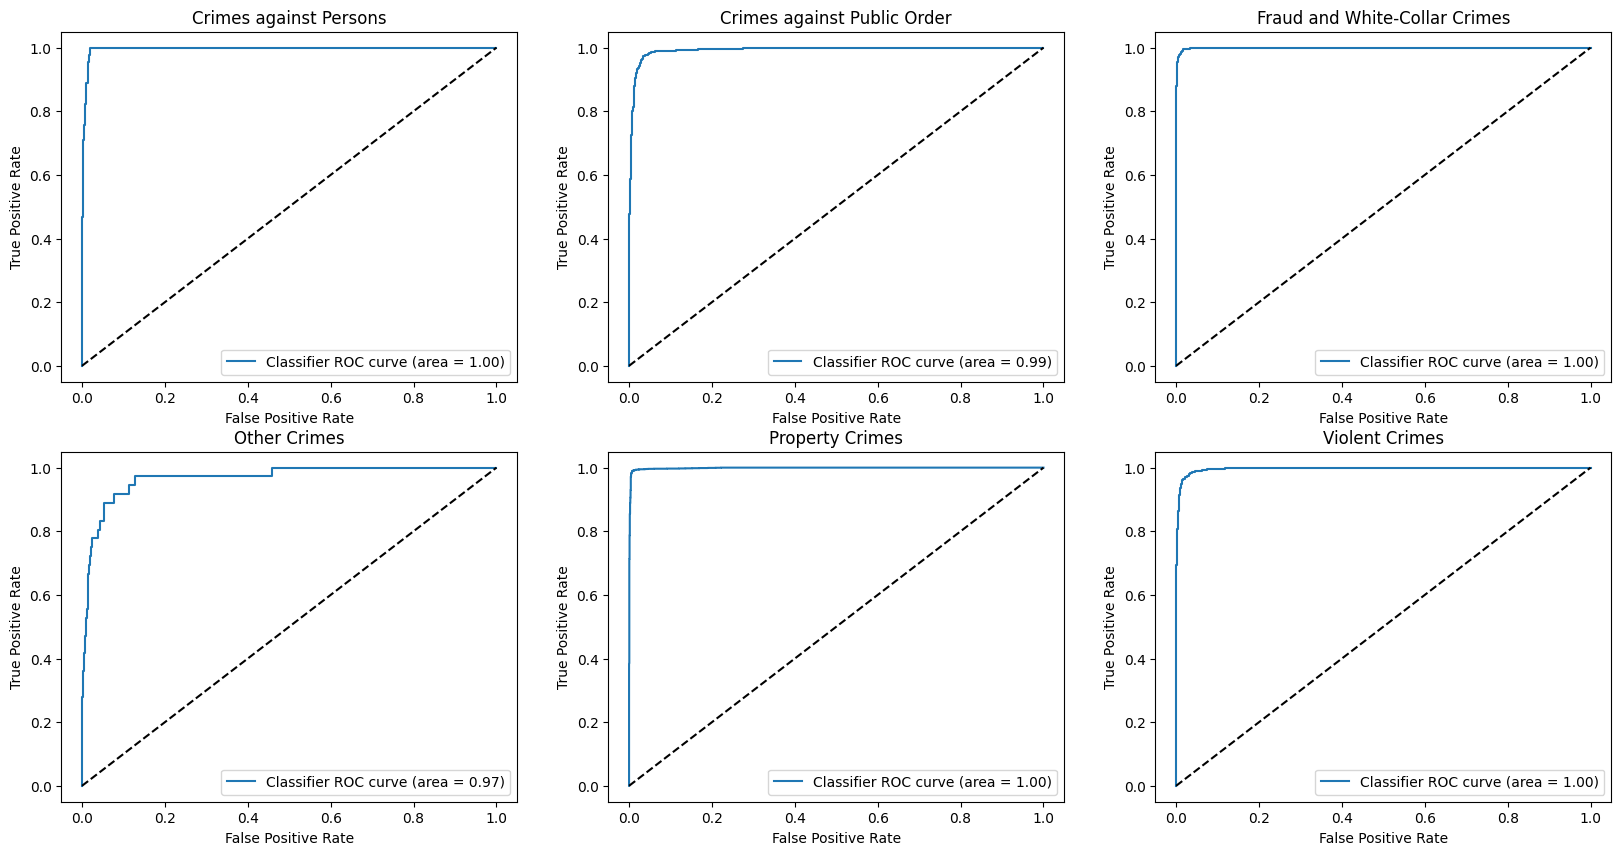

In [58]:
check_auc(xgbc, roc=1)

# 6) MLP

In [59]:
mlpc = MLPClassifier(random_state=42)
mlpc.fit(X_train, y_train)
check(mlpc)

train_accuracy_score           0.998
valid_accuracy_score           0.949


Stratified3Fold_mean           0.942
Stratified3Fold_std            0.005
valid_accuracy_score           0.949


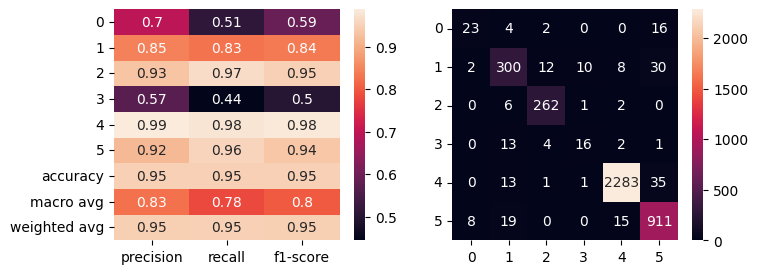

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


In [60]:
cross_check(mlpc)

==========================================Area Under Curve (ROC)=========================================


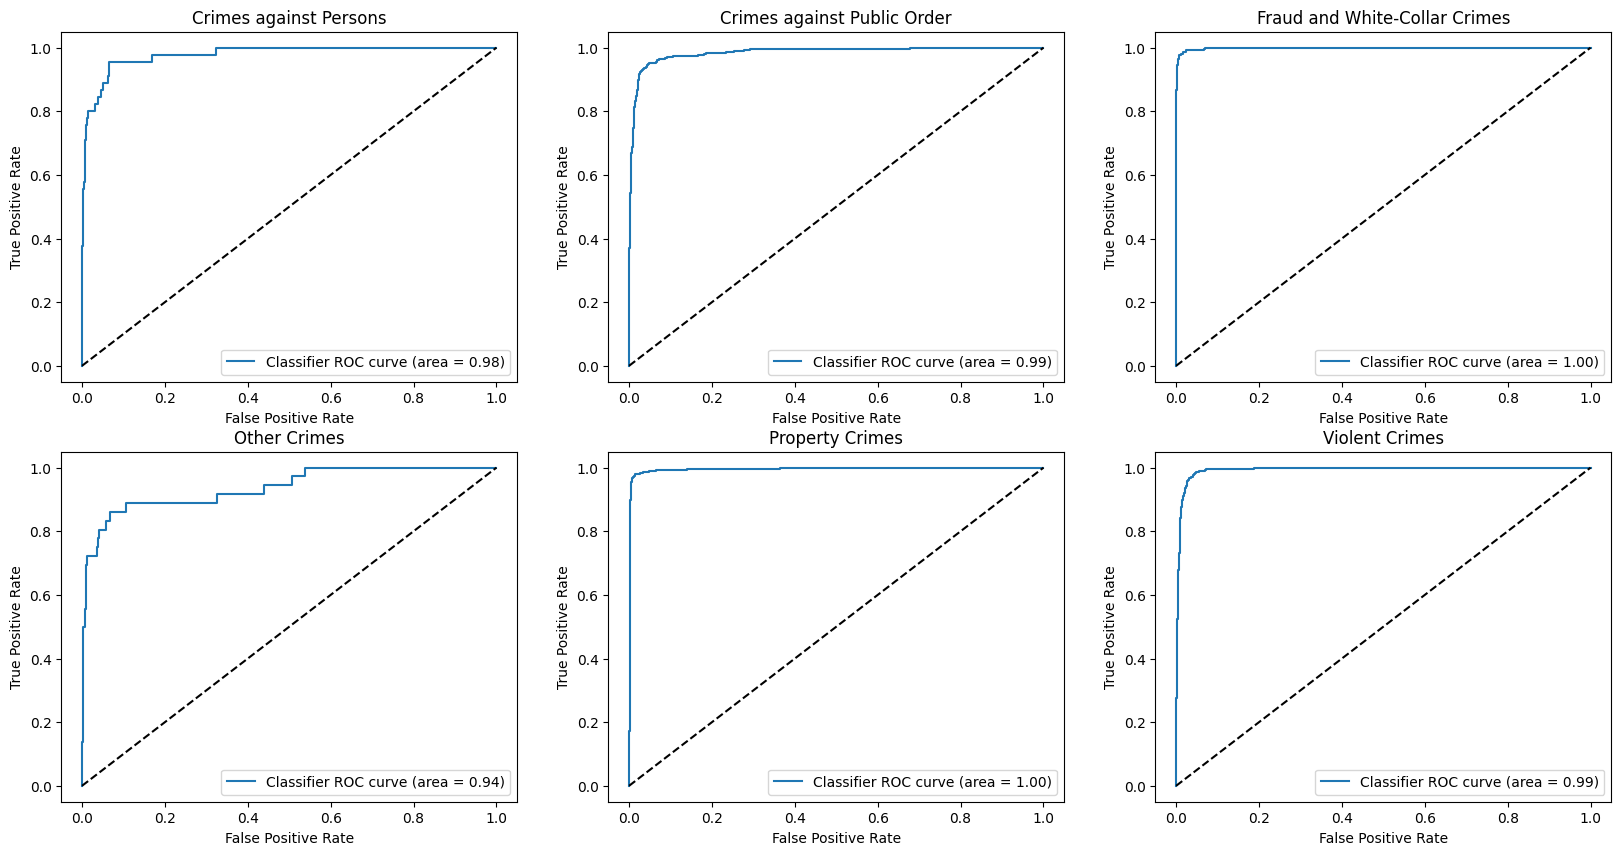

In [61]:
check_auc(mlpc, roc=1)

## Model Inspection

In [62]:
print('Number of layers                          ', mlpc.n_layers_)
print("Number of features in                     ", mlpc.n_features_in_)
print("100 neurons each taking 400 features      ", *mlpc.coefs_[0].shape)
print("100 intercept for each neurons            ", *mlpc.intercepts_[0].shape)
print("6 Outer neurons taking 100 neurons results", *mlpc.coefs_[1].shape)
print("6 Outer neurons intercepts                ", *mlpc.intercepts_[1].shape)
print("Number of outputs                         ", mlpc.n_outputs_)
print("Output activation function                ", mlpc.out_activation_)

Number of layers                           3
Number of features in                      586
100 neurons each taking 400 features       586 100
100 intercept for each neurons             100
6 Outer neurons taking 100 neurons results 100 6
6 Outer neurons intercepts                 6
Number of outputs                          6
Output activation function                 softmax


# Models Comparison


In [63]:
results = {
           'LogisticRegression': (lr.predict(X_val), lr.predict_proba(X_val)),
           'DecisionTreeClassifier': (dtc.predict(X_val), dtc.predict_proba(X_val)),
           'MLPClassifier': (mlpc.predict(X_val), mlpc.predict_proba(X_val)),
           'XGBClassifier': (xgbc.predict(X_val), xgbc.predict_proba(X_val))
           }

# Confusion Matrix

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


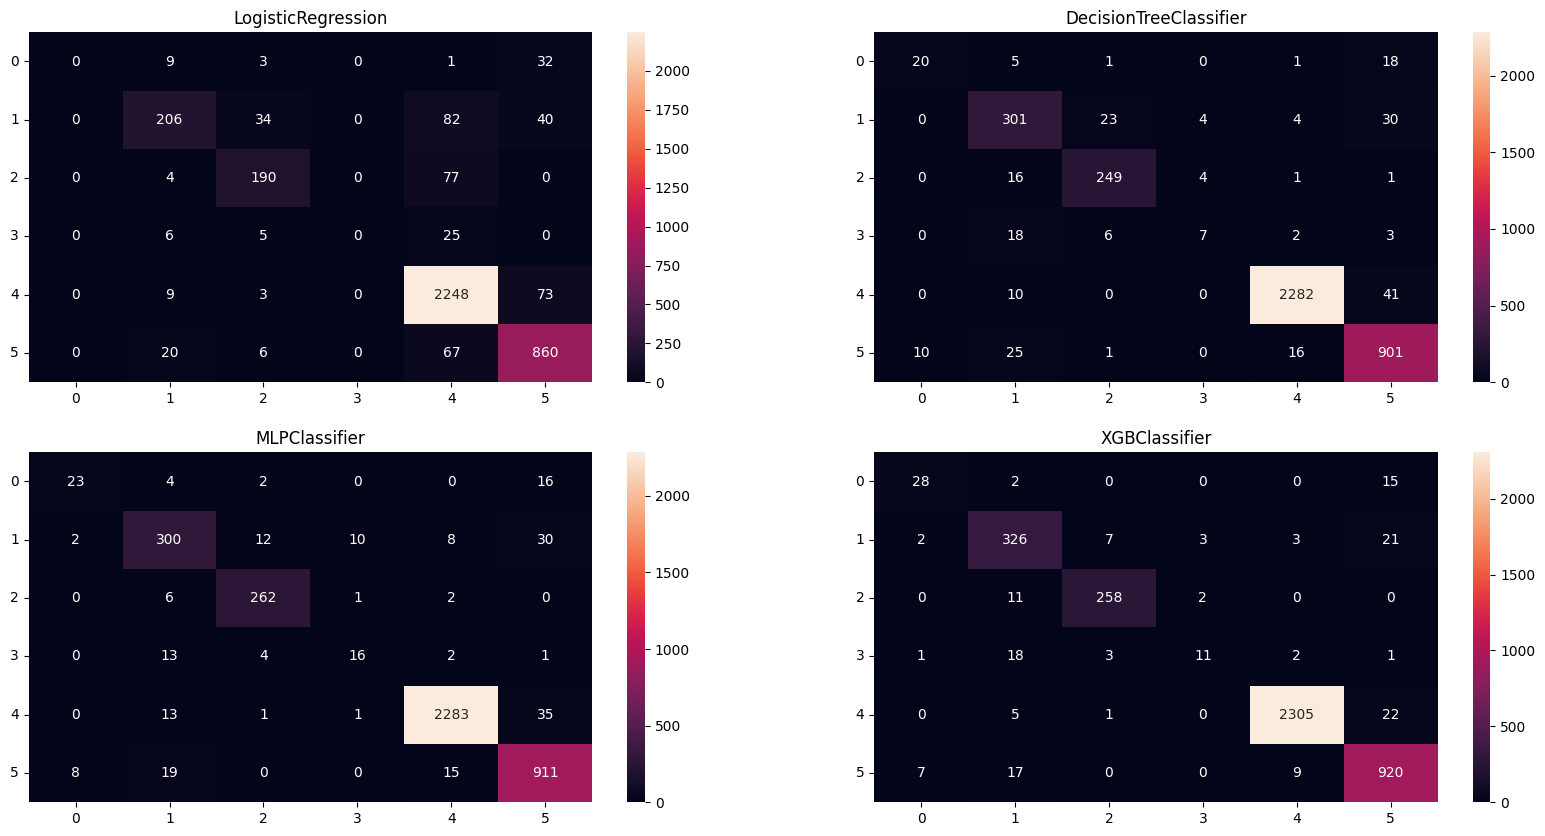

In [64]:
print(dict(zip(le.transform(le.classes_), le.classes_)))

# Confusion Matrix of 4 Models
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, (name, y_val_p) in enumerate(results.items()):
  cm = confusion_matrix(y_val, y_val_p[0])
  sns.heatmap(cm, annot=True, fmt='d', ax=axes[i//2, i%2])
  axes[i//2, i%2].set_title(name)
  axes[i//2, i%2].tick_params(axis='y', rotation=0)
plt.show()

* Ideally diagonal entries should be more, MLP classifier is working good for minoriy class 3 which is other crimes.

# Classification Report

{0: 'Crimes against Persons', 1: 'Crimes against Public Order', 2: 'Fraud and White-Collar Crimes', 3: 'Other Crimes', 4: 'Property Crimes', 5: 'Violent Crimes'}


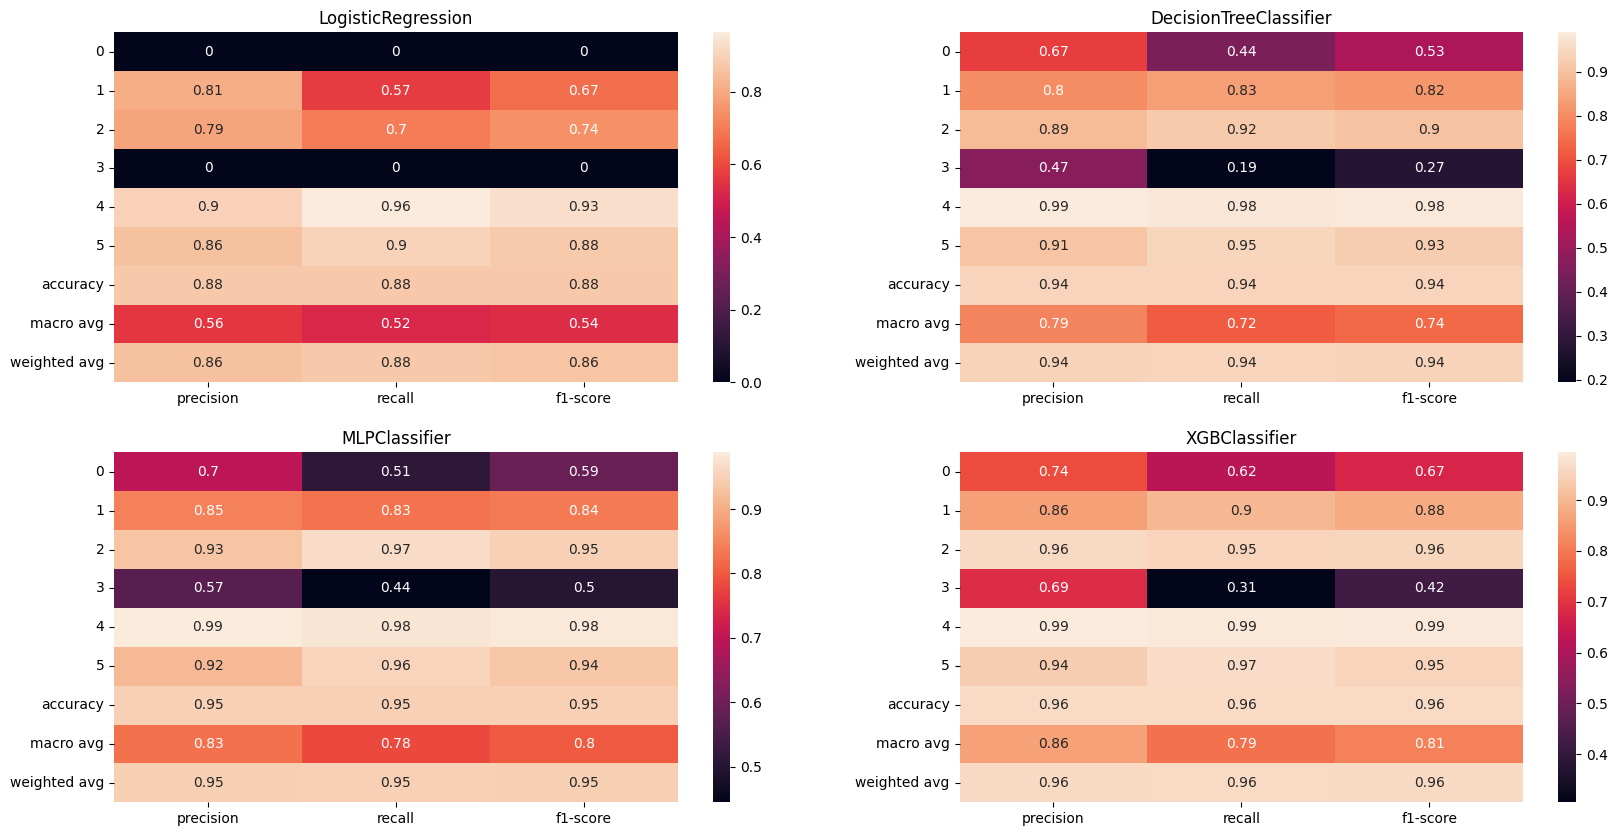

In [65]:
print(dict(zip(le.transform(le.classes_), le.classes_)))

# Classification of 4 Models
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
for i, (name, y_val_p) in enumerate(results.items()):
    report = classification_report(y_val, y_val_p[0], output_dict=True)
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, annot=True, ax=axes[i//2, i%2])
    axes[i//2, i%2].set_title(name)
    axes[i//2, i%2].tick_params(axis='y', rotation=0)
plt.show()

* Decision Tree performs badly with minority class (Other Crimes), because majority class dominates while splitting leads to poor consideration to minority classes


# F1 vs Accuracy

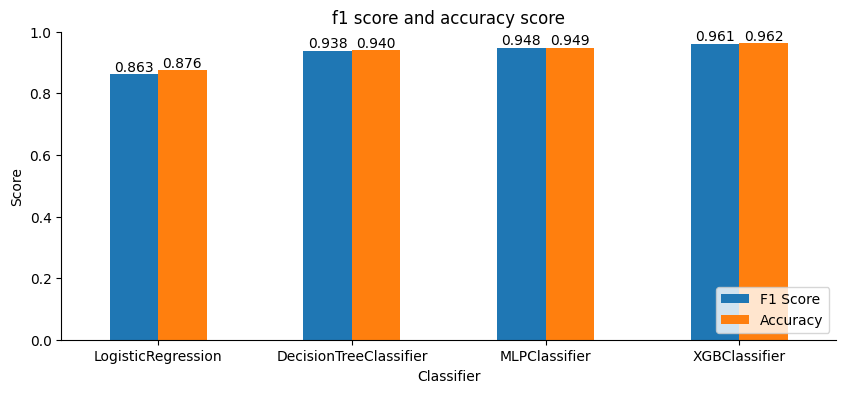

In [66]:
metrics = {
    'F1 Score': {name: f1_score(y_val, y_val_p[0], average='weighted') for name, y_val_p in results.items()},
    'Accuracy': {name: accuracy_score(y_val, y_val_p[0]) for name, y_val_p in results.items()}
}

fig, ax = plt.subplots(figsize=(10, 4))

# f1_score and accuracy_score of 4 Models
pd.DataFrame(metrics).plot(kind='bar', ax=ax)
ax.set_title('f1 score and accuracy score')
ax.set_xlabel('Classifier')
ax.set_ylabel('Score')
ax.set_ylim(0, 1)
ax.legend(loc='lower right')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.xticks(rotation=0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show()

* The models is not favoring any particular class disproportionately.
* Precision and recall across all crime category are balanced enough that the harmonic mean (F1 score) alsmost same as the accuracy.

# ROC Curve
**Receiver Operating Characteristics**

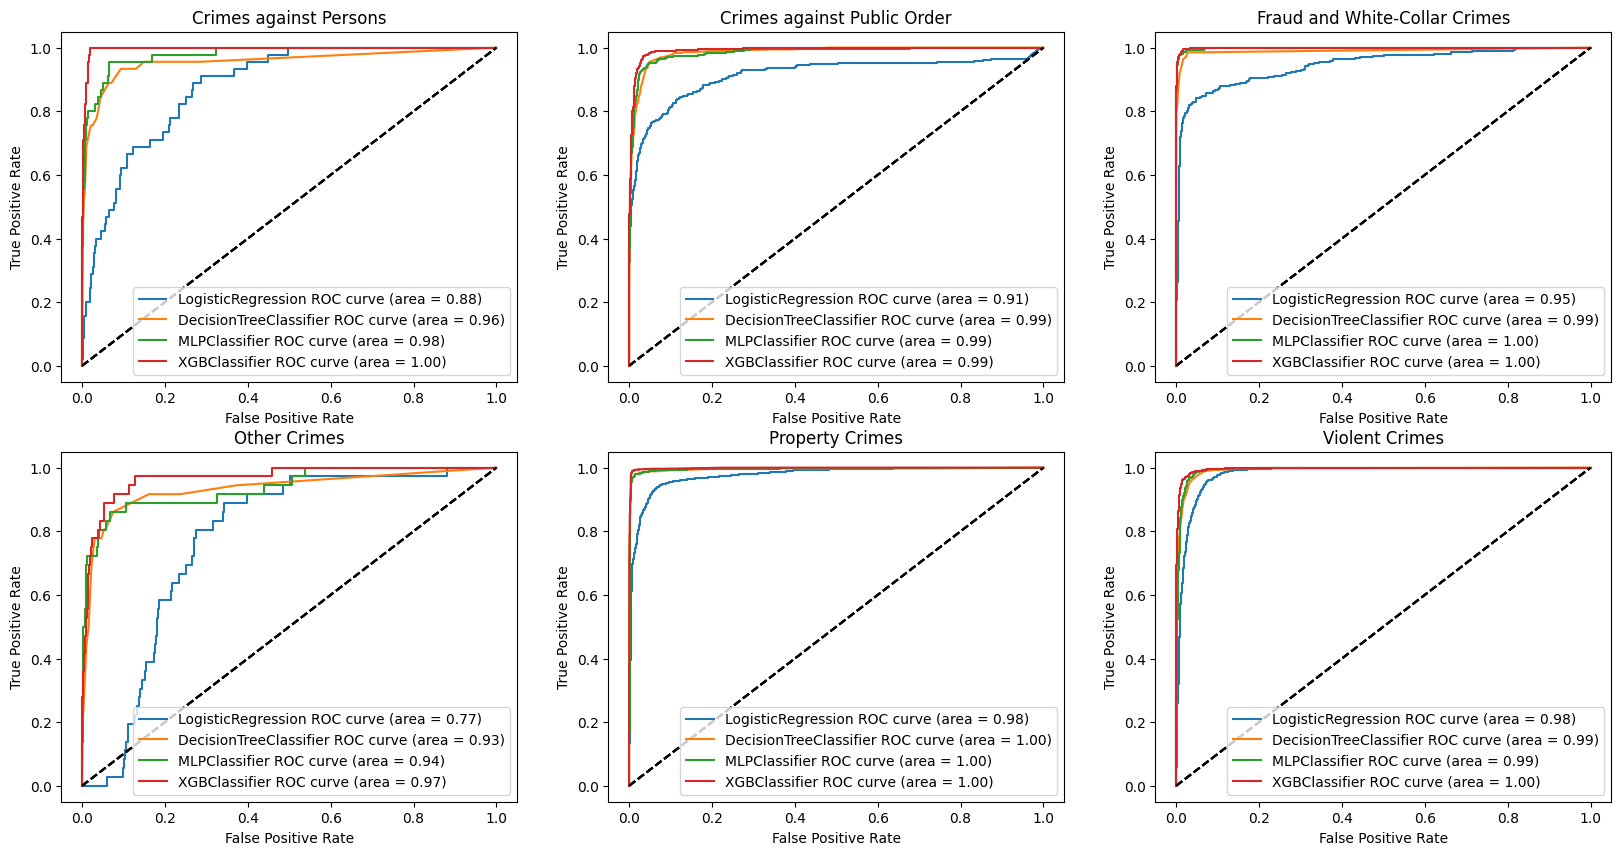

In [67]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

# ROC Curve of 4 Models
for i, crime in (dict(zip(le.transform(le.classes_), le.classes_))).items():
  for j, (model, y_val_p) in enumerate(results.items()):
    fpr, tpr, thresholds = roc_curve(label_binarize(y_val, classes=np.unique(y_val))[:, i],
                                     y_val_p[1][:, i])
    roc_auc = auc(fpr, tpr)
    axes[i//3, i%3].plot(fpr, tpr, label='%s ROC curve (area = %0.2f)' % (model, roc_auc))
    axes[i//3, i%3].plot([0, 1], [0, 1], 'k--')
    axes[i//3, i%3].set_title(crime)
    axes[i//3, i%3].set_ylabel('True Positive Rate')
    axes[i//3, i%3].set_xlabel('False Positive Rate')
    axes[i//3, i%3].legend(loc="lower right")
plt.show()

* The ROC curves to top left for each class signify the model is good at sensitiviy and specificity, but still other crimes is not as good as other crime classification

# 7) Bagging

In [68]:
# rfc = RandomForestClassifier(n_estimators=100, random_state=42)
# rfc.fit(X_train, y_train)
# check(rfc)

In [69]:
# vc = VotingClassifier([('mlpc', mlpc), ('xgbc', xgbc)], voting='soft')
# vc.fit(X_train, y_train)
# check(vc)

# Kaggle Submission

In [70]:
model = xgbc
model.fit(pipe.fit_transform(train_data.drop('Crime_Category', axis=1), y), y)
pd.DataFrame({
      'ID': range(1, test_data.shape[0]+1),
      'Crime_Category': le.inverse_transform(model.predict(pipe.transform(test_data)))
      }).to_csv('submission.csv', index=False);
print("made submission")

made submission


* Assignment of a label amount 6 labels for 5,000 data will have enumeration of $6^{5000}$ possibilities, which is huuuuuuuuuuuuuuge. Machine Learning Techniques will aid to assign 95% of unseen label correctly.
* I followed the Milestone provided by IITM to achieve this score. I heartfully thank MLP project instructors for their support and guidance.





# Leaderboard Improvement Experimentations

SMOTE

In [71]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

smote = SMOTE(random_state=42)
X_train_re, y_train_re = smote.fit_resample(X_train, y_train)
clf = XGBClassifier(random_state=42, seed=42, max_depth=6)
clf.fit(X_train_re, y_train_re)
print(f'{clf.score(X_val, y_val):.3f}')

0.962


In [72]:
# cv_scores = cross_val_score(clf, X_train_re, y_train_re,
#                             cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42))

In [73]:
# print(f'{clf.score(X_val, y_val)*10:.2f}')
# print(f'{cv_scores.mean()*10:.2f}', f'{cv_scores.std():.3f}')